# All imports

In [1]:
# import some common libraries
import os, json, cv2, random, shutil, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from tqdm import tqdm

%matplotlib inline

In [2]:
# setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

C:\Users\kdmei\anaconda3\envs\master\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# global variables and constants
datasets_dir = os.path.join('..', 'datasets')
json_file = os.path.join('..', 'datasets', 'gold_standard_complete.json')
with open(json_file) as f: data_json = json.load(f)
TRAIN_SPLIT = 0.7
RNG_SEED = 117

# Load in our own dataset

In [4]:
# load the functions to create the train and test split
%run Data-split-functions.ipynb

# create the data, set force_new_split to false so that we can skip 
# this phase if it has been done before and 
# extended to true to include the 'no_annotation' pages
split_data(TRAIN_SPLIT, False, True)

In [5]:
def get_redacted_dicts(img_dir):
    '''
    Get the annotations of the images in the provided directory in the format DatasetCatalog expects
    @param  string    The name of the 
    @return list      The annotations of the files in DatasetCatalog format. Every record has the following properties:
                          - filename:string      The name of the image
                          - image_id:int         The id of the image
                          - height:int           The height of the image
                          - width:int            The width of the image
                          - bbox_mode:string     The mode for the bounding box (BoxMode.XYWH_ABS or BoxMode.XYXY_ABS)
                          - bbox:list            The values for the bounding box depending on the bbox_mode
                          - semgentation:list    The separate semgentations that belong to the same instance
                          - category_id:int      The id of the class the instance belongs to
    '''

    # initial list of segments for this image
    dataset_dicts = []
    
    # iterate over all files/images in the porvided directory
    for idx, filename in tqdm(enumerate(os.listdir(img_dir))):
        
        # the initial record for this file
        record = {}
        
        # get the image
        img_path = os.path.join(img_dir, filename)
        image = cv2.imread(img_path)
        
        # skip this image if we can't load the file
        if image is None: continue
            
        # get the height and width of the image
        height, width = image.shape[:2]
        
        # keep track of some image properties
        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # skip this file if we don't have annotations for it
        if not filename in data_json: continue

        # get all polygons of this file
        polygons = [region['shape_attributes'] for region in data_json[filename]['regions']]
        
        # initial annotation of this file
        annotations = []
        
        # iterate over all polygons of this file
        for polygon in polygons:
            
            # handle rectangle polygons
            if polygon['name'] == 'rect':
                
                # create the values needed for the rectangular polygon
                # the values that the segmentation propery expect is:
                # [x1, y1, x2, y2, ..., xn, yn]
                segment = [polygon['x'], polygon['y']]
                segment = segment + [polygon['x'] + polygon['width'], polygon['y']]
                segment = segment + [polygon['x'] + polygon['width'], polygon['y'] + polygon['height']]
                segment = segment + [polygon['x'], polygon['y'] + polygon['height']]

                # create a bounding box for this segment
                bbox = [polygon['x'], polygon['y'], polygon['width'], polygon['height']]
                bbox_mode = BoxMode.XYWH_ABS
                
            # handle generic polygons
            elif polygon['name'] == 'polygon':
                
                # create the segmentation from all x and y values of the polygon
                # the values that the segmentation propery expect is:
                # [x1, y1, x2, y2, ..., xn, yn]
                px = polygon["all_points_x"]
                py = polygon["all_points_y"]
                segment = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                segment = [p for x in segment for p in x]
                
                # create the bounding box for this segment
                bbox = [np.min(px), np.min(py), np.max(px), np.max(py)]
                bbox_mode = BoxMode.XYXY_ABS
            
            # skip unknown polygon types
            else: continue
            
            # add the semgent specification 
            annotations.append({
                "bbox": bbox,
                "bbox_mode": bbox_mode,
                "segmentation": [segment],
                "category_id": 0,
            })
            
        # add the annotations to the record
        record["annotations"] = annotations
        
        # add the record to the dataset
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:
# create the dataset catalog and metadata for the train data
DatasetCatalog.register('redacted_train_extended', lambda x='train':get_redacted_dicts(os.path.join(datasets_dir, x)))
metadata = MetadataCatalog.get('redacted_train_extended').set(thing_classes=["redacted"])
metadata.set(thing_dataset_id_to_contiguous_id = {'0' : 'redacted'})
metadata.set(stuff_dataset_id_to_contiguous_id = {})
redacted_metadata = MetadataCatalog.get('redacted_train_extended')

# Create the config for the model
This is a reference to the default config with all available options: https://detectron2.readthedocs.io/en/latest/modules/config.html#yaml-config-references

In [7]:
# initial config for the detectron2 model
cfg = get_cfg() # the default config
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")) # the config of the coco dataset
cfg.SEED = RNG_SEED 

# data config
cfg.DATASETS.TRAIN = ("redacted_train_extended",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 # this will alter the speed of the training, my gpu could only handle 2
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # we also want the model to train on documents without redactions
cfg.INPUT.RANDOM_FLIP = "none" # we don't add any random flips as data augmentation

# model config
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # initial weights from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # The "RoIHead batch size". The default is 512, but a smaller size is faster
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class* ('redacted')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # inference score threshold 
# *NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# set a custom output directory for this model
# so that we don't overwrite the model of the 
# other experiment
cfg.OUTPUT_DIR = 'output_extended'

# create the output dir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [8]:
# solver config that we need to use a gridsearch on
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    
cfg.SOLVER.STEPS = []        # do not decay learning rate

# Train the model with our data

In [9]:
# train the model 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/23 13:33:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

664it [00:43, 15.43it/s]

[01/23 13:33:49 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  redacted  | 7765         |
|            |              |
[01/23 13:33:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[01/23 13:33:49 d2.data.build]: Using training sampler TrainingSampler
[01/23 13:33:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/23 13:33:49 d2.data.common]: Serializing 664 elements to byte tensors and concatenating them all ...
[01/23 13:33:49 d2.data.common]: Serialized dataset takes 0.61 MiB
[01/23 13:33:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl ...



Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) i

[01/23 13:33:51 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\kdmei\anaconda3\envs\master\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/23 13:34:15 d2.utils.events]:  eta: 1:25:32  iter: 19  total_loss: 5.549  loss_cls: 0.6246  loss_box_reg: 0.2599  loss_mask: 0.6826  loss_rpn_cls: 3.455  loss_rpn_loc: 0.3258    time: 0.9944  last_time: 1.0429  data_time: 0.1888  last_data_time: 0.0012   lr: 1.9981e-05  max_mem: 5218M
[01/23 13:34:40 d2.utils.events]:  eta: 1:25:44  iter: 39  total_loss: 2.171  loss_cls: 0.5456  loss_box_reg: 0.3955  loss_mask: 0.5891  loss_rpn_cls: 0.3132  loss_rpn_loc: 0.2269    time: 1.0267  last_time: 1.0392  data_time: 0.0013  last_data_time: 0.0014   lr: 3.9961e-05  max_mem: 5933M
[01/23 13:35:01 d2.utils.events]:  eta: 1:25:52  iter: 59  total_loss: 1.655  loss_cls: 0.3747  loss_box_reg: 0.3656  loss_mask: 0.4569  loss_rpn_cls: 0.1805  loss_rpn_loc: 0.2205    time: 1.0318  last_time: 1.1361  data_time: 0.0014  last_data_time: 0.0013   lr: 5.9941e-05  max_mem: 5933M
[01/23 13:35:21 d2.utils.events]:  eta: 1:25:13  iter: 79  total_loss: 1.604  loss_cls: 0.3921  loss_box_reg: 0.5527  loss_mask:

[01/23 13:43:55 d2.utils.events]:  eta: 1:16:34  iter: 579  total_loss: 0.6485  loss_cls: 0.1076  loss_box_reg: 0.2301  loss_mask: 0.1226  loss_rpn_cls: 0.01978  loss_rpn_loc: 0.1317    time: 1.0273  last_time: 1.4220  data_time: 0.0013  last_data_time: 0.0012   lr: 0.00057942  max_mem: 5933M
[01/23 13:44:15 d2.utils.events]:  eta: 1:16:15  iter: 599  total_loss: 0.6788  loss_cls: 0.1092  loss_box_reg: 0.2523  loss_mask: 0.1579  loss_rpn_cls: 0.01855  loss_rpn_loc: 0.1276    time: 1.0268  last_time: 0.8335  data_time: 0.0013  last_data_time: 0.0015   lr: 0.0005994  max_mem: 5933M
[01/23 13:44:35 d2.utils.events]:  eta: 1:15:53  iter: 619  total_loss: 0.6177  loss_cls: 0.1259  loss_box_reg: 0.2452  loss_mask: 0.1437  loss_rpn_cls: 0.01543  loss_rpn_loc: 0.1157    time: 1.0256  last_time: 0.9946  data_time: 0.0013  last_data_time: 0.0013   lr: 0.00061938  max_mem: 5933M
[01/23 13:44:56 d2.utils.events]:  eta: 1:15:35  iter: 639  total_loss: 0.5579  loss_cls: 0.1123  loss_box_reg: 0.2067 

[01/23 13:53:40 d2.utils.events]:  eta: 1:07:50  iter: 1139  total_loss: 0.5755  loss_cls: 0.08811  loss_box_reg: 0.2152  loss_mask: 0.1367  loss_rpn_cls: 0.01162  loss_rpn_loc: 0.08812    time: 1.0357  last_time: 1.0301  data_time: 0.0014  last_data_time: 0.0012   lr: 0.001  max_mem: 5933M
[01/23 13:54:01 d2.utils.events]:  eta: 1:07:32  iter: 1159  total_loss: 0.5604  loss_cls: 0.09086  loss_box_reg: 0.2066  loss_mask: 0.1378  loss_rpn_cls: 0.01097  loss_rpn_loc: 0.1071    time: 1.0360  last_time: 1.0049  data_time: 0.0013  last_data_time: 0.0014   lr: 0.001  max_mem: 5933M
[01/23 13:54:21 d2.utils.events]:  eta: 1:07:07  iter: 1179  total_loss: 0.5026  loss_cls: 0.08866  loss_box_reg: 0.1743  loss_mask: 0.137  loss_rpn_cls: 0.009849  loss_rpn_loc: 0.06047    time: 1.0358  last_time: 0.9386  data_time: 0.0013  last_data_time: 0.0013   lr: 0.001  max_mem: 5933M
[01/23 13:54:42 d2.utils.events]:  eta: 1:06:47  iter: 1199  total_loss: 0.6506  loss_cls: 0.101  loss_box_reg: 0.2592  loss_

[01/23 14:03:27 d2.utils.events]:  eta: 0:58:18  iter: 1699  total_loss: 0.601  loss_cls: 0.08389  loss_box_reg: 0.2264  loss_mask: 0.1397  loss_rpn_cls: 0.006619  loss_rpn_loc: 0.1103    time: 1.0396  last_time: 1.0228  data_time: 0.0014  last_data_time: 0.0021   lr: 0.001  max_mem: 5935M
[01/23 14:03:48 d2.utils.events]:  eta: 0:58:04  iter: 1719  total_loss: 0.4088  loss_cls: 0.0661  loss_box_reg: 0.1655  loss_mask: 0.1075  loss_rpn_cls: 0.004639  loss_rpn_loc: 0.07758    time: 1.0401  last_time: 1.1508  data_time: 0.0013  last_data_time: 0.0013   lr: 0.001  max_mem: 5935M
[01/23 14:04:10 d2.utils.events]:  eta: 0:57:46  iter: 1739  total_loss: 0.5477  loss_cls: 0.08114  loss_box_reg: 0.2021  loss_mask: 0.1291  loss_rpn_cls: 0.009569  loss_rpn_loc: 0.1151    time: 1.0407  last_time: 1.0915  data_time: 0.0014  last_data_time: 0.0014   lr: 0.001  max_mem: 5935M
[01/23 14:04:32 d2.utils.events]:  eta: 0:57:23  iter: 1759  total_loss: 0.4562  loss_cls: 0.0749  loss_box_reg: 0.1751  loss

[01/23 14:13:18 d2.utils.events]:  eta: 0:48:38  iter: 2259  total_loss: 0.6014  loss_cls: 0.07805  loss_box_reg: 0.2054  loss_mask: 0.1376  loss_rpn_cls: 0.01632  loss_rpn_loc: 0.1286    time: 1.0435  last_time: 1.0359  data_time: 0.0013  last_data_time: 0.0012   lr: 0.001  max_mem: 5935M
[01/23 14:13:38 d2.utils.events]:  eta: 0:48:12  iter: 2279  total_loss: 0.5402  loss_cls: 0.07944  loss_box_reg: 0.2096  loss_mask: 0.1307  loss_rpn_cls: 0.009669  loss_rpn_loc: 0.09156    time: 1.0432  last_time: 0.8262  data_time: 0.0014  last_data_time: 0.0010   lr: 0.001  max_mem: 5935M
[01/23 14:13:59 d2.utils.events]:  eta: 0:47:50  iter: 2299  total_loss: 0.4398  loss_cls: 0.05795  loss_box_reg: 0.1709  loss_mask: 0.1278  loss_rpn_cls: 0.003208  loss_rpn_loc: 0.07598    time: 1.0433  last_time: 1.0094  data_time: 0.0013  last_data_time: 0.0012   lr: 0.001  max_mem: 5935M
[01/23 14:14:21 d2.utils.events]:  eta: 0:47:28  iter: 2319  total_loss: 0.5248  loss_cls: 0.08832  loss_box_reg: 0.1881  l

[01/23 14:23:07 d2.utils.events]:  eta: 0:38:47  iter: 2819  total_loss: 0.5973  loss_cls: 0.08334  loss_box_reg: 0.2385  loss_mask: 0.1389  loss_rpn_cls: 0.006496  loss_rpn_loc: 0.126    time: 1.0450  last_time: 1.4065  data_time: 0.0014  last_data_time: 0.0011   lr: 0.001  max_mem: 5935M
[01/23 14:23:27 d2.utils.events]:  eta: 0:38:23  iter: 2839  total_loss: 0.4968  loss_cls: 0.06179  loss_box_reg: 0.1857  loss_mask: 0.1337  loss_rpn_cls: 0.009087  loss_rpn_loc: 0.08377    time: 1.0449  last_time: 0.8556  data_time: 0.0013  last_data_time: 0.0013   lr: 0.001  max_mem: 5935M
[01/23 14:23:49 d2.utils.events]:  eta: 0:38:04  iter: 2859  total_loss: 0.4737  loss_cls: 0.07415  loss_box_reg: 0.1855  loss_mask: 0.1285  loss_rpn_cls: 0.002847  loss_rpn_loc: 0.07279    time: 1.0451  last_time: 1.0230  data_time: 0.0013  last_data_time: 0.0013   lr: 0.001  max_mem: 5935M
[01/23 14:24:10 d2.utils.events]:  eta: 0:37:41  iter: 2879  total_loss: 0.4198  loss_cls: 0.05234  loss_box_reg: 0.163  lo

[01/23 14:32:57 d2.utils.events]:  eta: 0:28:55  iter: 3379  total_loss: 0.4654  loss_cls: 0.0633  loss_box_reg: 0.1874  loss_mask: 0.1306  loss_rpn_cls: 0.005715  loss_rpn_loc: 0.07671    time: 1.0465  last_time: 1.1764  data_time: 0.0013  last_data_time: 0.0014   lr: 0.001  max_mem: 5937M
[01/23 14:33:18 d2.utils.events]:  eta: 0:28:34  iter: 3399  total_loss: 0.5101  loss_cls: 0.06715  loss_box_reg: 0.1908  loss_mask: 0.1265  loss_rpn_cls: 0.004665  loss_rpn_loc: 0.08827    time: 1.0465  last_time: 0.7996  data_time: 0.0013  last_data_time: 0.0014   lr: 0.001  max_mem: 5937M
[01/23 14:33:39 d2.utils.events]:  eta: 0:28:12  iter: 3419  total_loss: 0.48  loss_cls: 0.05648  loss_box_reg: 0.1939  loss_mask: 0.1203  loss_rpn_cls: 0.005354  loss_rpn_loc: 0.07502    time: 1.0465  last_time: 1.0610  data_time: 0.0013  last_data_time: 0.0012   lr: 0.001  max_mem: 5937M
[01/23 14:34:01 d2.utils.events]:  eta: 0:27:52  iter: 3439  total_loss: 0.4236  loss_cls: 0.06827  loss_box_reg: 0.166  los

[01/23 14:42:42 d2.utils.events]:  eta: 0:18:50  iter: 3939  total_loss: 0.4751  loss_cls: 0.06236  loss_box_reg: 0.1841  loss_mask: 0.117  loss_rpn_cls: 0.003487  loss_rpn_loc: 0.07753    time: 1.0460  last_time: 1.0110  data_time: 0.0013  last_data_time: 0.0013   lr: 0.001  max_mem: 5937M
[01/23 14:43:02 d2.utils.events]:  eta: 0:18:27  iter: 3959  total_loss: 0.3963  loss_cls: 0.05173  loss_box_reg: 0.1675  loss_mask: 0.1146  loss_rpn_cls: 0.00319  loss_rpn_loc: 0.07555    time: 1.0459  last_time: 0.8116  data_time: 0.0014  last_data_time: 0.0013   lr: 0.001  max_mem: 5937M
[01/23 14:43:22 d2.utils.events]:  eta: 0:18:03  iter: 3979  total_loss: 0.4349  loss_cls: 0.05588  loss_box_reg: 0.1774  loss_mask: 0.1039  loss_rpn_cls: 0.004789  loss_rpn_loc: 0.07004    time: 1.0457  last_time: 0.8315  data_time: 0.0013  last_data_time: 0.0014   lr: 0.001  max_mem: 5937M
[01/23 14:43:43 d2.utils.events]:  eta: 0:17:41  iter: 3999  total_loss: 0.422  loss_cls: 0.05535  loss_box_reg: 0.1654  lo

[01/23 14:55:54 d2.utils.events]:  eta: 0:09:42  iter: 4499  total_loss: 0.4488  loss_cls: 0.05667  loss_box_reg: 0.1946  loss_mask: 0.1174  loss_rpn_cls: 0.005818  loss_rpn_loc: 0.08123    time: 1.0919  last_time: 1.5703  data_time: 0.0015  last_data_time: 0.0013   lr: 0.001  max_mem: 5937M
[01/23 14:56:22 d2.utils.events]:  eta: 0:09:21  iter: 4519  total_loss: 0.4227  loss_cls: 0.05748  loss_box_reg: 0.17  loss_mask: 0.1044  loss_rpn_cls: 0.005073  loss_rpn_loc: 0.06068    time: 1.0933  last_time: 1.4704  data_time: 0.0014  last_data_time: 0.0013   lr: 0.001  max_mem: 5937M
[01/23 14:56:53 d2.utils.events]:  eta: 0:08:59  iter: 4539  total_loss: 0.4747  loss_cls: 0.06114  loss_box_reg: 0.1847  loss_mask: 0.1174  loss_rpn_cls: 0.008778  loss_rpn_loc: 0.08698    time: 1.0953  last_time: 1.4835  data_time: 0.0014  last_data_time: 0.0012   lr: 0.001  max_mem: 5937M
[01/23 14:57:23 d2.utils.events]:  eta: 0:08:37  iter: 4559  total_loss: 0.3665  loss_cls: 0.05016  loss_box_reg: 0.14  los

# Evaluation
I personally restart the kernel here to empty the memory and rerun everything except the trainer cell above.

In [9]:
# global variables and constants for the evaluation
IOU_THRESHOLD = 0.5
data_csv = pd.read_csv(os.path.join(datasets_dir, 'data_complete.csv'))

In [10]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold (in this case the same as the training threshold)
predictor = DefaultPredictor(cfg)

[01/25 13:02:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output_extended\model_final.pth ...


In [11]:
def create_gold_standard_masks(input_image_path):
    '''
    Create a separate mask for every annotated region of an image
    @param  string      The path to the image
    @return np.array    The numpy array representation of the masks with the 
                        dimensions of the image and the golden 
                        standard region drawn on it. Only the golden standard
                        region coordinates have the value True, the rest 
                        is False.
    '''
    
    # load the image
    input_image = cv2.imread(input_image_path)
    
    # get the golden standard for the image
    gold_standard_image = data_json[os.path.split(input_image_path)[-1]]
    
    # make sure that we have the golden standard for the image
    if not gold_standard_image: return None
    
    # get the golden standard regions for the image
    gold_standard_regions = gold_standard_image['regions']
    
    # extract the polygons from the regions
    polygons = [r['shape_attributes'] for r in gold_standard_regions]
    
    # array holding all masks
    masks = []
    
    combinedmask = np.zeros(np.array(input_image).shape, dtype = "uint8")
    
    # construct the polygon arrays and add them to the mask
    for polygon in polygons:
        
        # create the initial mask (black) with the dimensions of the original image
        mask = np.zeros(np.array(input_image).shape, dtype = "uint8")
        
        if polygon['name'] == 'rect':
            bottom_left = [polygon['x'], polygon['y']]
            bottom_right = [polygon['x']+polygon['width'], polygon['y']]
            top_right = [polygon['x']+polygon['width'], polygon['y']+polygon['height']]
            top_left = [polygon['x'], polygon['y']+polygon['height']]
            
            gold_standard_polygon_xy = [bottom_left, bottom_right, top_right, top_left]
        else:
            # If not a rectangle we have a more complex shape and we just add all points to it
            gold_standard_polygon_xy  = [[polygon['all_points_x'][i], polygon['all_points_y'][i]] for i in range(0, len(polygon['all_points_x']))]

        # add the polygon (white) to the mask
        mask = cv2.fillPoly(mask, [np.array(gold_standard_polygon_xy, np.int32)], (255,255,255))   
        combinedmask = cv2.fillPoly(combinedmask, [np.array(gold_standard_polygon_xy, np.int32)], (255,255,255)) 
        
        # save the mask with a single channel with boolean values
        masks.append(np.array(mask).astype(bool)[:, :, 0])
        
    
    plt.figure(figsize=(20, 20))
    plt.imshow(combinedmask)
    plt.show()

    # return the masks
    return masks

In [12]:
def metric_calculation(dataframe):
    '''
    The metric calculations as done in https://github.com/irlabamsterdam/TPDLTextRedaction/blob/main/notebooks/Experiments.ipynb
    @param  pd.DataFrame    The dataframe for one class with the following columns { IOU, TP, FN, FP }
                            where the IOU is the sum of IOU scores and the others a total count.
    @return dict            The metric scores for this class
    '''
    
    SQ = dataframe['IOU'].sum() / dataframe['TP'].sum() if dataframe['TP'].sum() > 0 else 0
    RQ = dataframe['TP'].sum() / (dataframe['TP'].sum() + 0.5*dataframe['FN'].sum() + 0.5*dataframe['FP'].sum())
    PQ = SQ*RQ
    P = dataframe['TP'].sum() / (dataframe['TP'].sum() + dataframe['FP'].sum()) if (dataframe['TP'].sum() + dataframe['FP'].sum()) > 0 else 0
    R = dataframe['TP'].sum() / (dataframe['TP'].sum() + dataframe['FN'].sum()) if (dataframe['TP'].sum() + dataframe['FN'].sum()) > 0 else 0
    
    return { 'PQ': round(PQ, 2), 'SQ': round(SQ, 2), 'RQ': round(RQ, 2), 'P': round(P, 2), 'R': round(R, 2) }

In [17]:
# Function to remove the overlap between predicted masks
# this should also speed up the calculation of the overall PQ score
def remove_box_overlap(predicted_masks, scores, score_t: float=0.5, iou_t: float= 0.5):
    '''
    Remove the overlap between predicted masks
    @param  list    The predicted masks
    @param  list    The confidence scores of the predicted masks
    @param  float   The prediction confidence score threshold
    @param  float   The interval-over-intersection threshold to consider
                    an annotated region and predicted region a true positive
    @return
    '''
    
    # Filter out boxes with a low confidence score
    filtered_masks = [predicted_masks[i].numpy() for i in range(len(predicted_masks)) if scores[i] > score_t]
    filtered_scores = [scores[i] for i in range(len(scores)) if scores[i] > score_t]
    
    # Sort boxes based on their confidence scores
    sorted_masks = np.array(filtered_masks)[np.argsort(filtered_scores)]
    
    # The list was sorted from worst to best score so we have to reverse the list
    sorted_masks = sorted_masks[::-1]
    
    # after the first step, we have to remove overlaps by looping through and calculating iou
    if not len(sorted_masks):
        return None
    
    # By definition we always include the first mask in the output
    output_masks = [sorted_masks[0]]
    mask_overlap = sorted_masks[0]
    
    for mask in output_masks:
        print('---------------------------output mask before--------------------------')
        plt.figure(figsize=(20, 20))
        plt.imshow(mask)
        plt.show()
    
    print('-------------------mask 0------------------')
    plt.figure(figsize=(20, 20))
    plt.imshow(sorted_masks[0])
    plt.show()
    
    # evaluate all masks
    for i in range(1, len(sorted_masks)):
        print('shtihtithihthithit', i)
        
        print('--------------mask----------------')
        plt.figure(figsize=(20, 20))
        plt.imshow(sorted_masks[i])
        plt.show()
        
        # get the mask size
        mask_size = (sorted_masks[i] > 0).sum()
        
        for mask in output_masks:
            print('---------------------------output mask during--------------------------')
            plt.figure(figsize=(20, 20))
            plt.imshow(mask)
            plt.show()
        
        # check if the current mask has any overlap with previously evaluated masks
        only_mask = np.logical_and((sorted_masks[i]==1), (mask_overlap == 0))
        
        for mask in output_masks:
            print('---------------------------output mask after onlymask--------------------------')
            plt.figure(figsize=(20, 20))
            plt.imshow(mask)
            plt.show()
        
        print('---------------------------onlymask--------------------------')
        plt.figure(figsize=(20, 20))
        plt.imshow(only_mask)
        plt.show()
        
        print(only_mask.sum() / mask_size, iou_t)
        
        # only keep masks that do not overlap for more
        # than the given IoU threshold with the previous masks
        if (only_mask.sum() / mask_size) > iou_t:
            output_masks.append(only_mask)
            mask_overlap += only_mask
            mask_overlap = mask_overlap > 0
            
    for mask in output_masks:
        print('---------------------------output mask--------------------------')
        plt.figure(figsize=(20, 20))
        plt.imshow(mask)
        plt.show()
            
    # only return the masks if we have them
    if len(output_masks): return np.stack(output_masks)
    else: return None

In [18]:
def get_PQ_score(ground_truth, prediction):
    '''
    Get the values that are needed to calculate the PQ-score
    @param  np.array    The ground truth masks
    @param  np.array    The predicted masks
    @return dict        The values needed for the PQ-score (TP, FP, FN, IOU)
    '''
    
    # make sure that the prediction
    # is always numpy array by default
    if prediction is None: prediction = np.array([])
        
    # get the initial values
    TP = []
    IOU = []
    
    # get the indices of the ground truth and prediction masks
    gt_indices = list(range(ground_truth.shape[0]))
    pred_indices = list(range(prediction.shape[0]))
    
#     print(gt_indices)
    print('aaaaaaaas', ground_truth.shape)

    # iterate over the ground truth and prediction 
    # masks to calculate the iou between all combinations
    for i in range(ground_truth.shape[0]):
        for j in range(prediction.shape[0]):
            
            # calculate the iou between this ground truth
            # and predicted mask
            ground_truth_mask = ground_truth[i, :, :]
            predicted_mask = prediction[j, :, :]
#             print(i, j)
#             plt.figure(figsize=(20, 20))
#             plt.imshow(ground_truth_mask)
#             plt.show()
            
#             plt.figure(figsize=(20, 20))
#             plt.imshow(predicted_mask)
#             plt.show()
            
            
            print(i, np.sum(ground_truth_mask), j, np.sum(predicted_mask))
            union = ((ground_truth_mask + predicted_mask) > 0).sum()
            intersection = (predicted_mask * ground_truth_mask).sum()
            iou = intersection / union
            print(i, j, iou)
            # add this combination of masks as a true positive if
            # the iou exceeds the threshold and keep track of the
            # iou score for the segmentation quality metric
            if iou > 0.5:
#                 print(i, j)
                TP.append((i, j))
                IOU.append(iou)
#                 print(TP[0])
                    
    # every unused predicted mask is a false positive
    FP = set(pred_indices)-set([item[1] for item in TP])
    
    # every unused ground truth maks is a false negative
    FN = set(gt_indices)-set([item[0] for item in TP])
    
    # return the values needed for the panoptic quality metric
    return {'TP': len(TP), 'FP': len(FP), 'FN': len(FN), 'IOU': sum(IOU)}

In [19]:
def extract_panoptic_evaluation_values(image_path, score_t: float=0.5, iou_t: float= 0.5):
    '''
    Function to evaluate how well the detection is for an image
    @param  string  The path to the image
    @param  float   The prediction confidence score threshold
    @param  float   The interval-over-intersection threshold to consider
                    an annotated region and predicted region a true positive
    @return dict    The dict with the evaluation scores:
                        - iou:float  The sum of the intersection over union values of all true positive regions
                        - tp:int     The number of true positives
                        - fp:int     The number of false positives
                        - fn:int     The number of false negatives
    '''
    
    # get the golden standard masks for the image
    im = cv2.imread(image_path)
    g_masks = create_gold_standard_masks(image_path)
    
    # get the filename from the path
    filename = os.path.split(image_path)[-1]
    
    # get the label
    label = data_csv[data_csv['File'] == filename].type.item()
    
    # get the prediction masks for the image
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    p_masks = outputs['instances'].pred_masks.cpu()
    scores = outputs['instances'].scores.cpu()
    
    print('pmasks shape', np.array(p_masks).shape)
    
    for pmask in p_masks:
        print('------------------------pmask-----------------------------')
        plt.figure(figsize=(20, 20))
        plt.imshow(pmask)
        plt.show()
    
    # filter the prediction masks by removing the overlap between them
    filtered_p_masks = remove_box_overlap(p_masks, scores, score_t, iou_t)
    
    for pmask in filtered_p_masks:
        print('------------------------filtered masks-----------------------------')
        plt.figure(figsize=(20, 20))
        plt.imshow(pmask)
        plt.show()
    
    # get the PQ score
    pq = get_PQ_score(np.array(g_masks), filtered_p_masks)
    
    # add the redacted area of the predictions
    # and the total size of the image 
    pq['area'] = np.sum(filtered_p_masks)
    w, h, _ = im.shape
    pq['size'] = w*h
    
    # add the label to the score
    pq['Label'] = label
    
    #return the pq score
    return pq

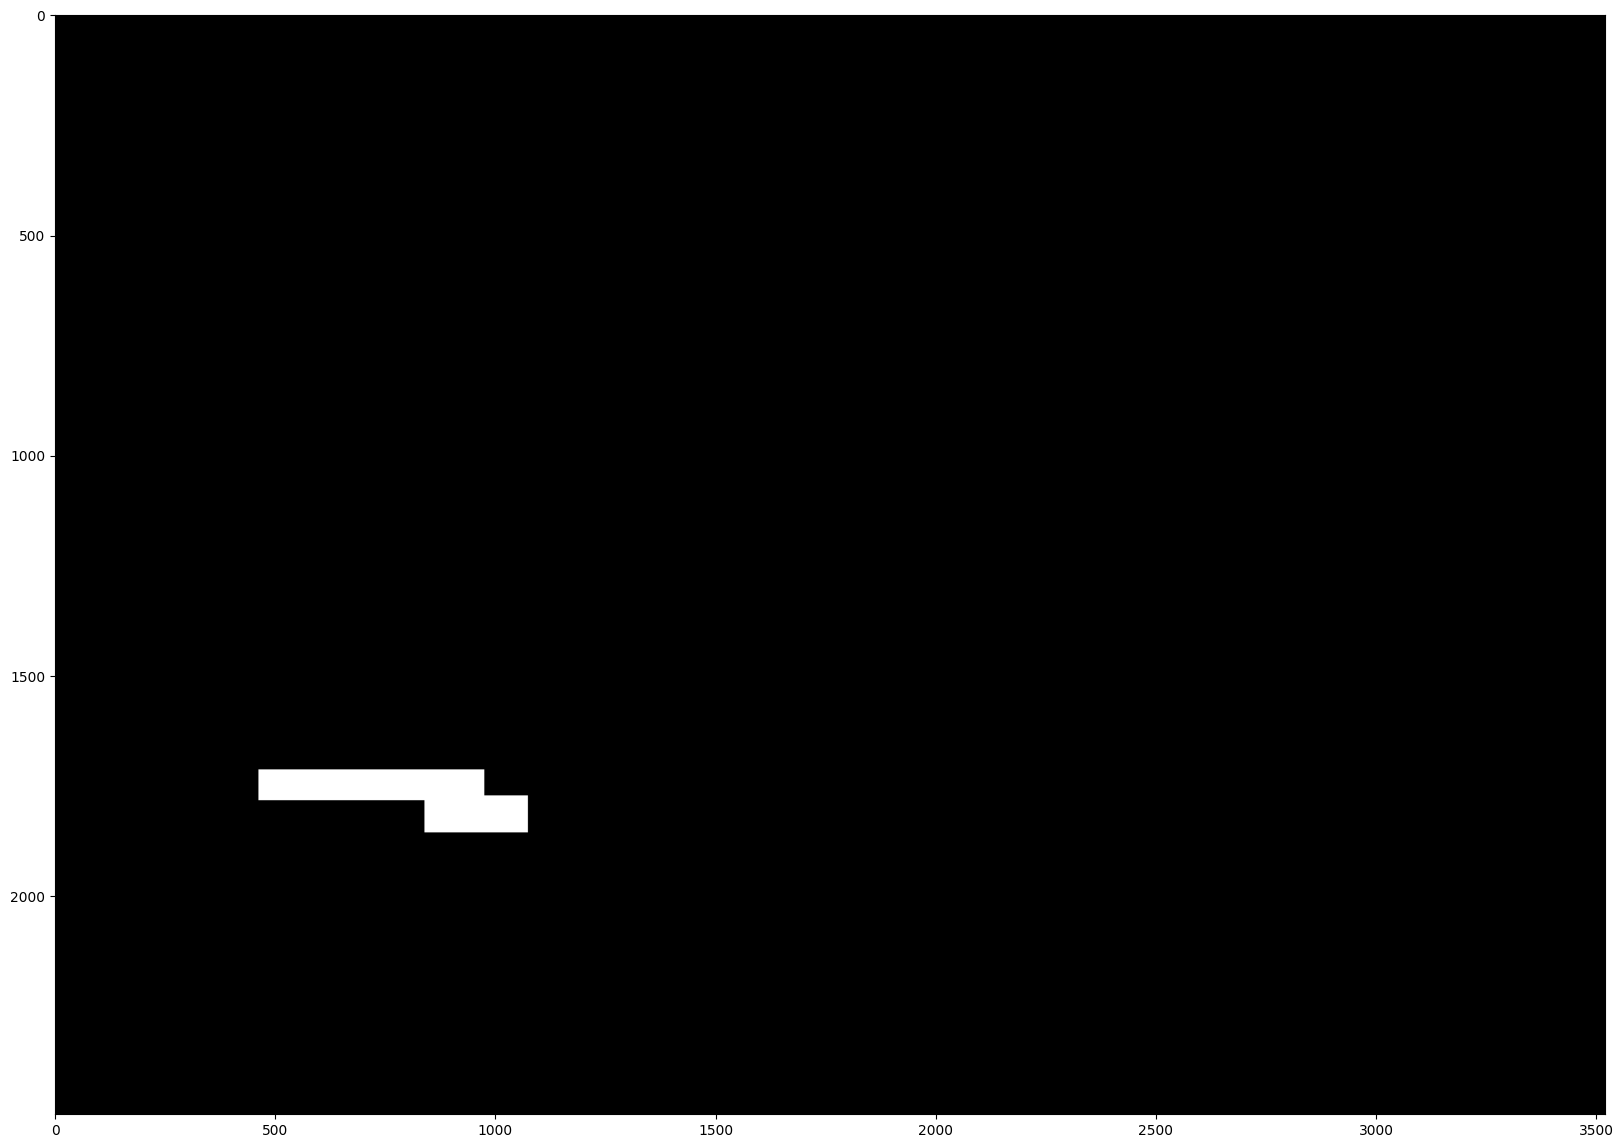

pmasks shape (2, 2496, 3520)
------------------------pmask-----------------------------


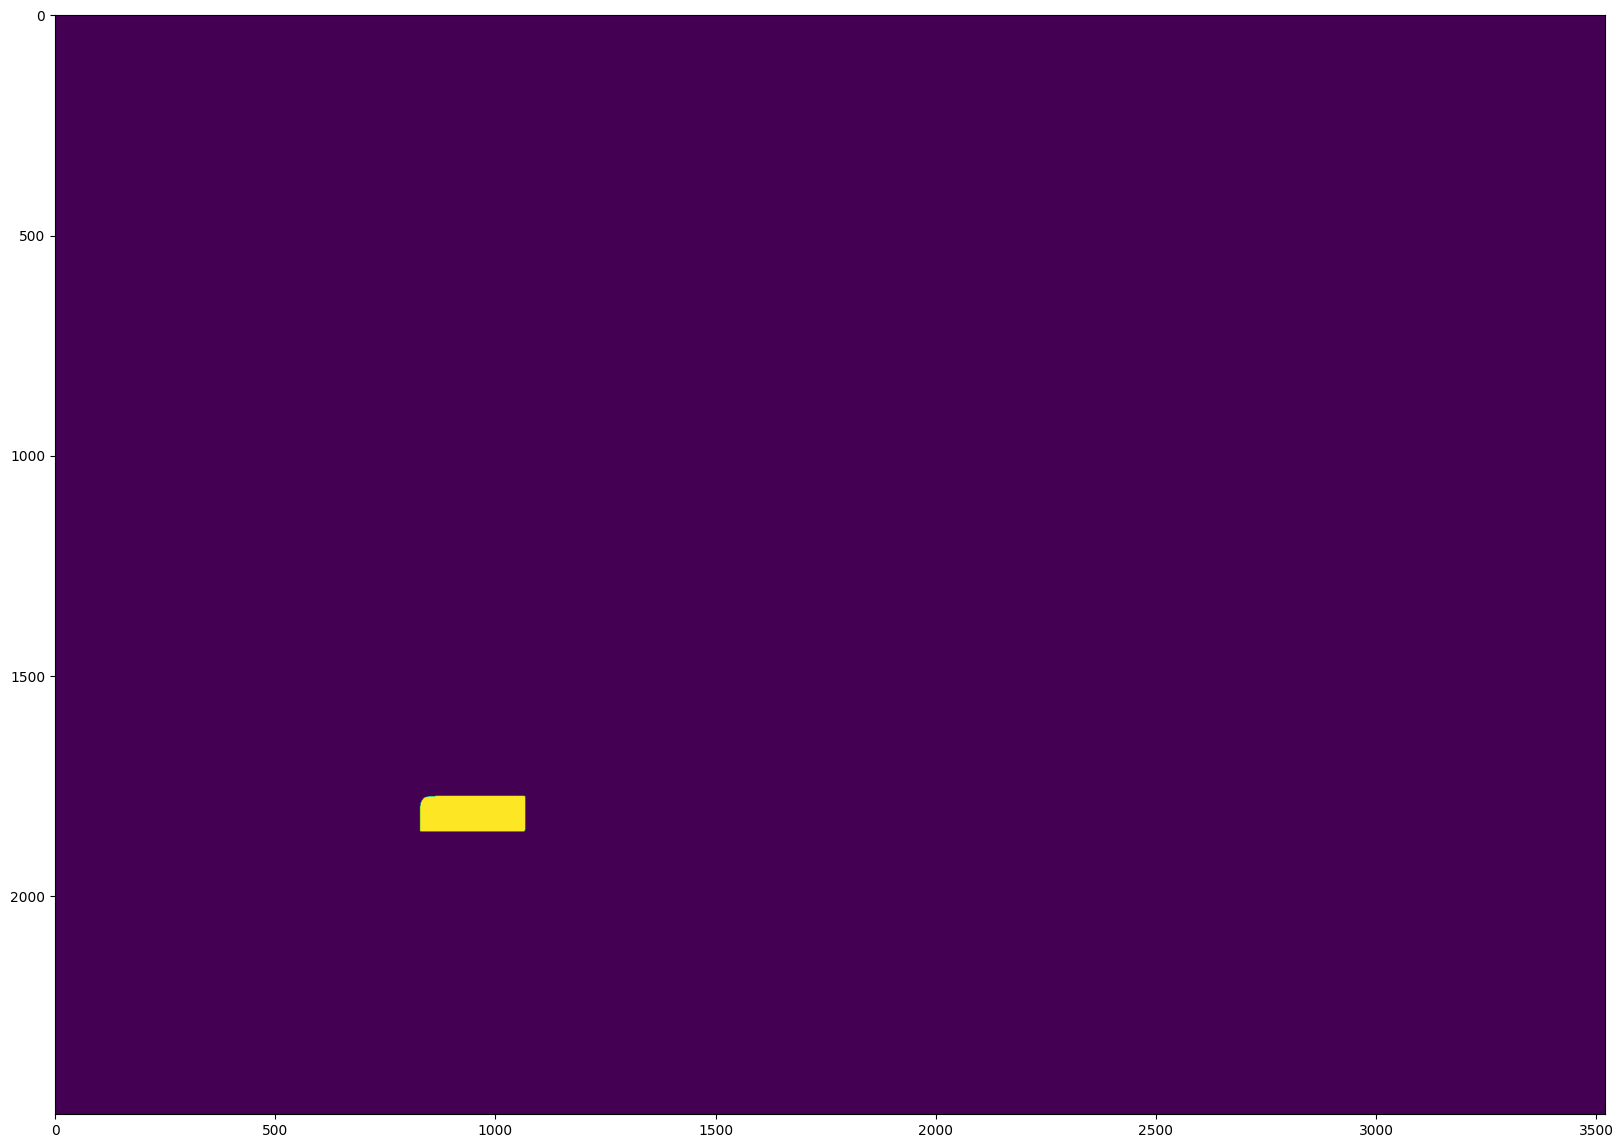

------------------------pmask-----------------------------


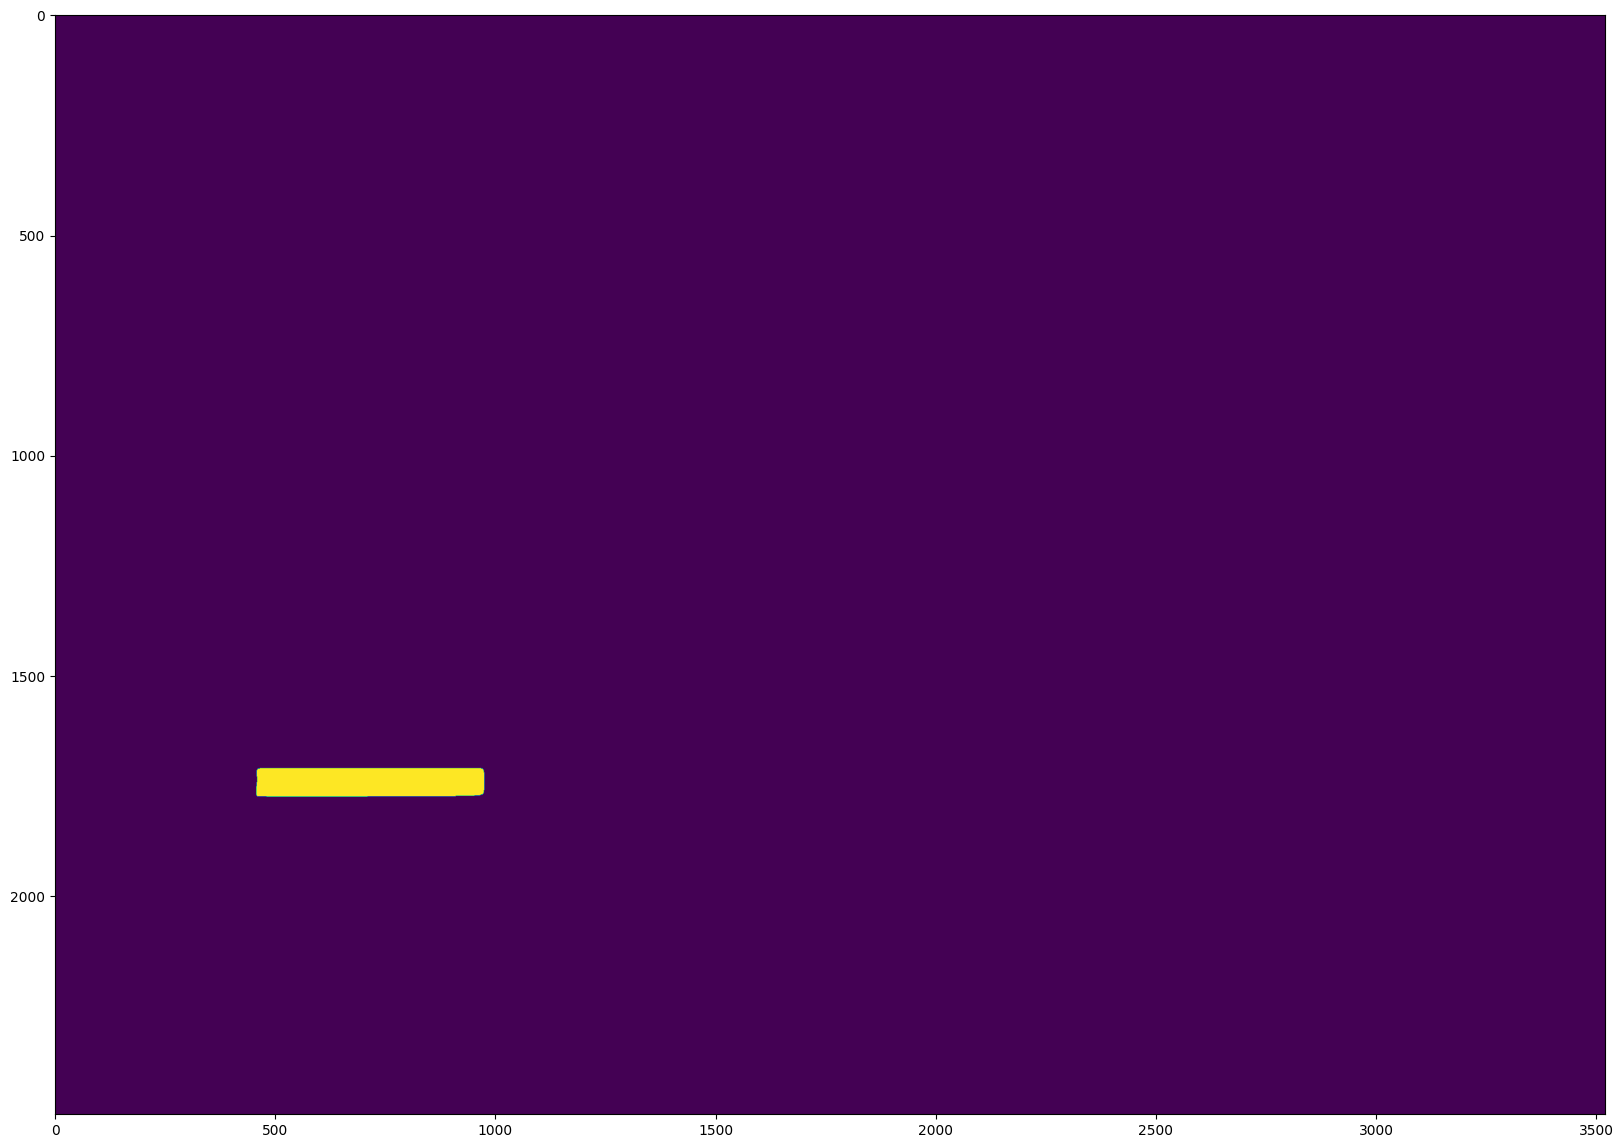

---------------------------output mask before--------------------------


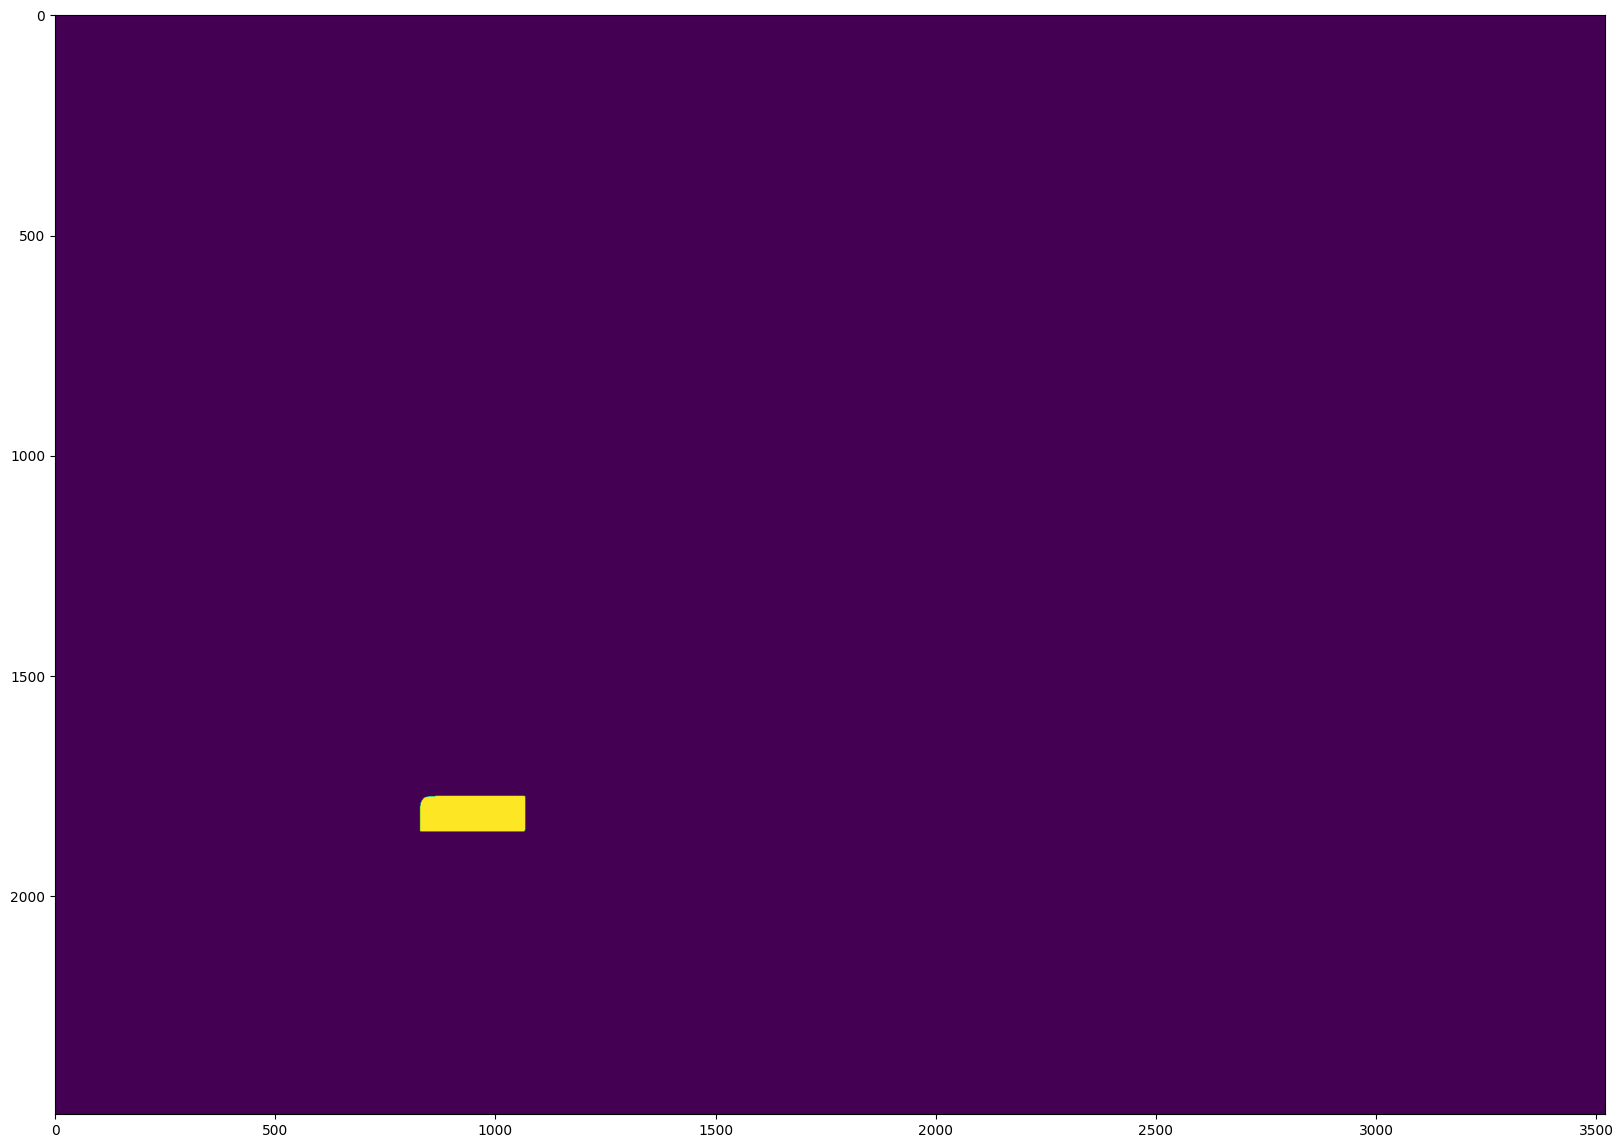

-------------------mask 0------------------


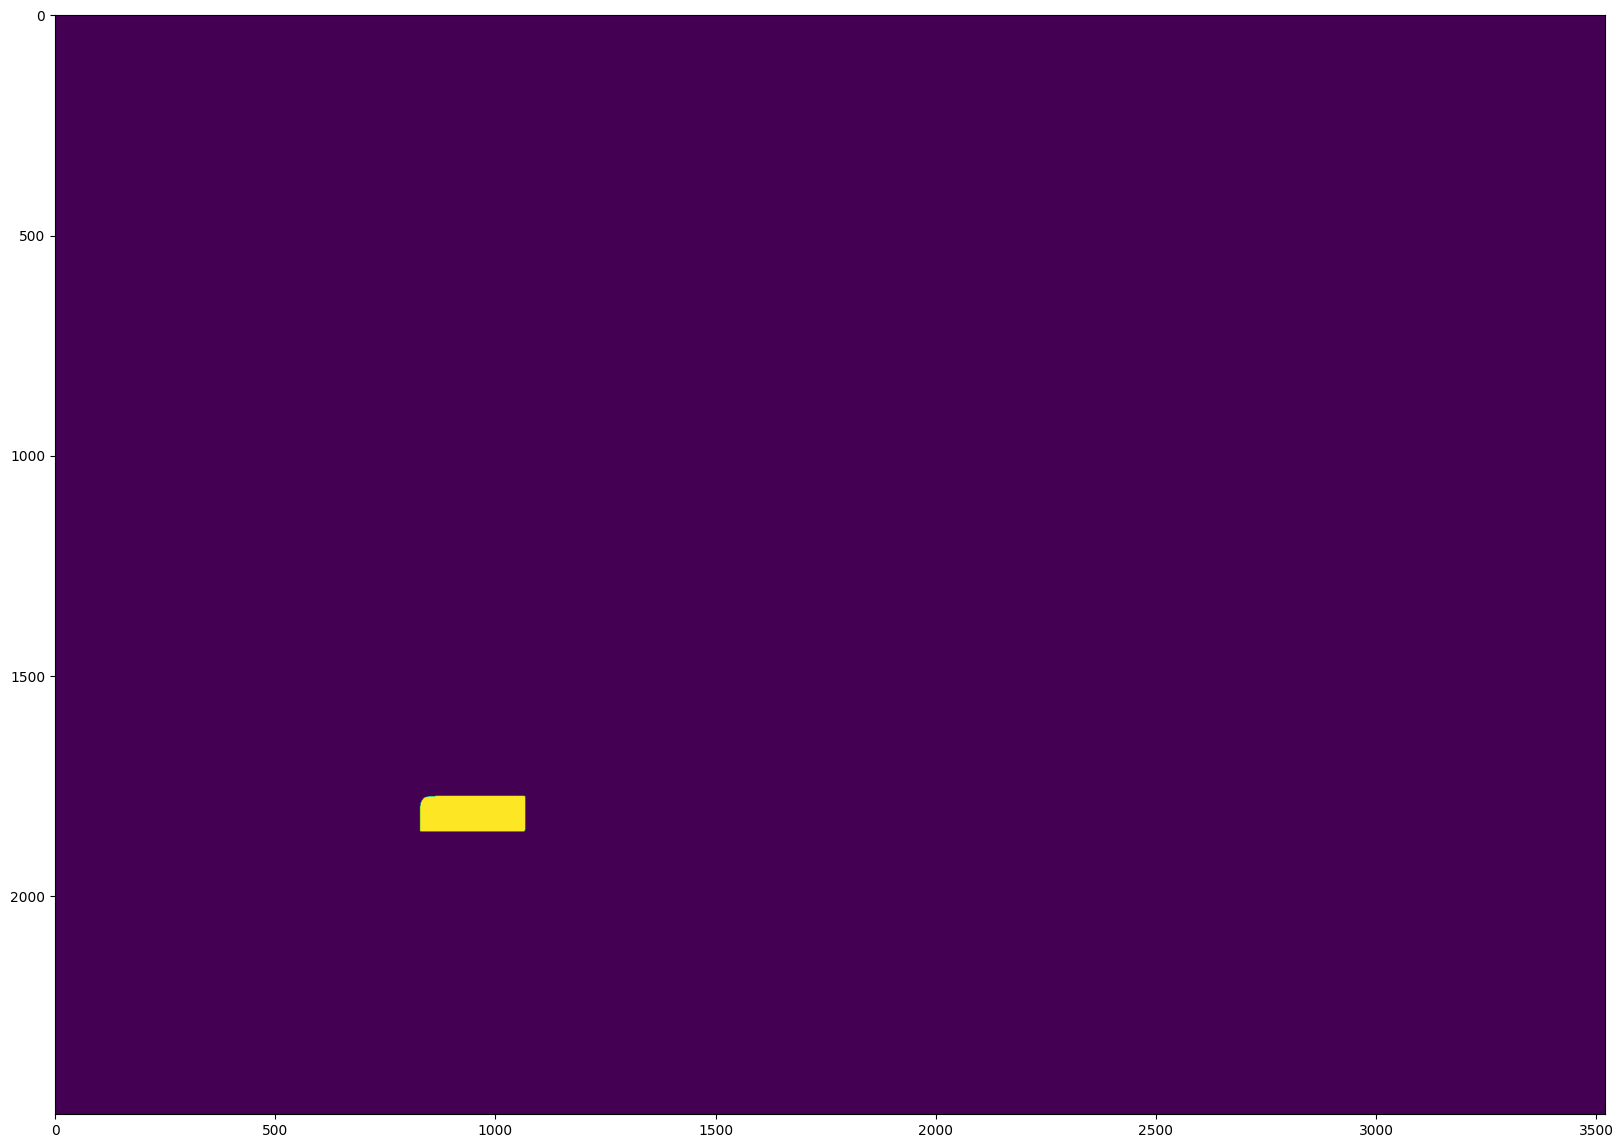

shtihtithihthithit 1
--------------mask----------------


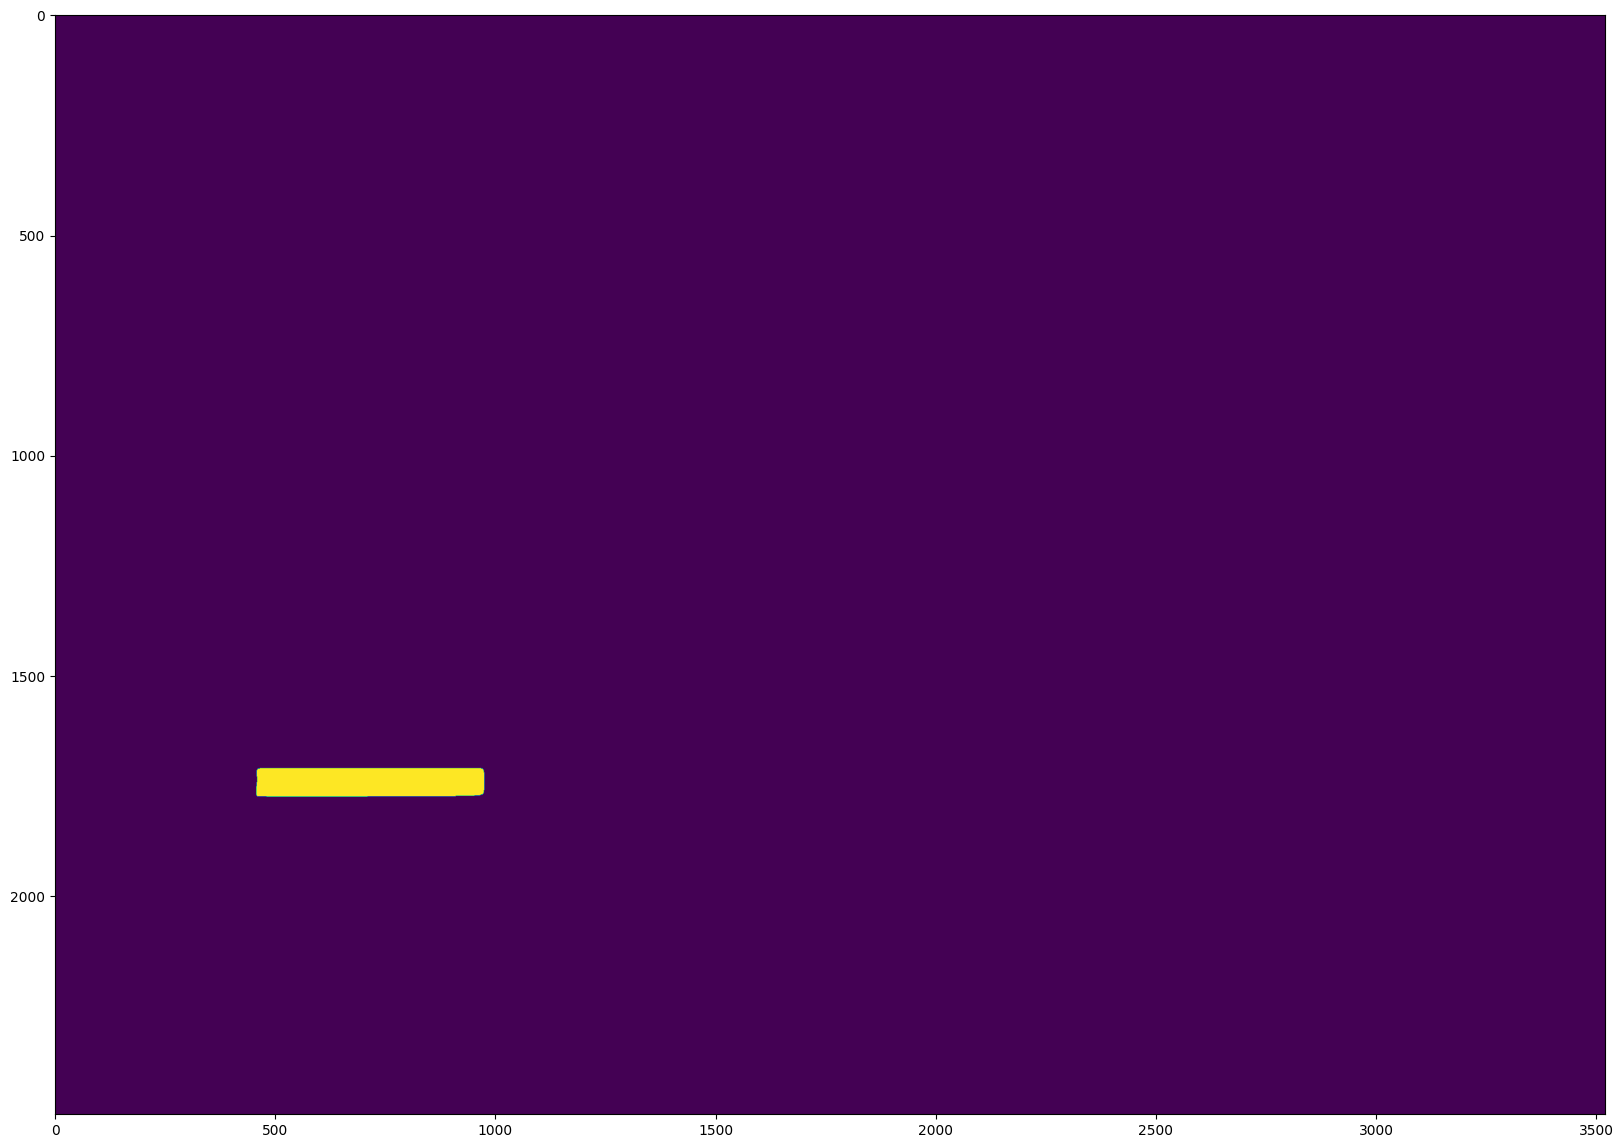

---------------------------output mask during--------------------------


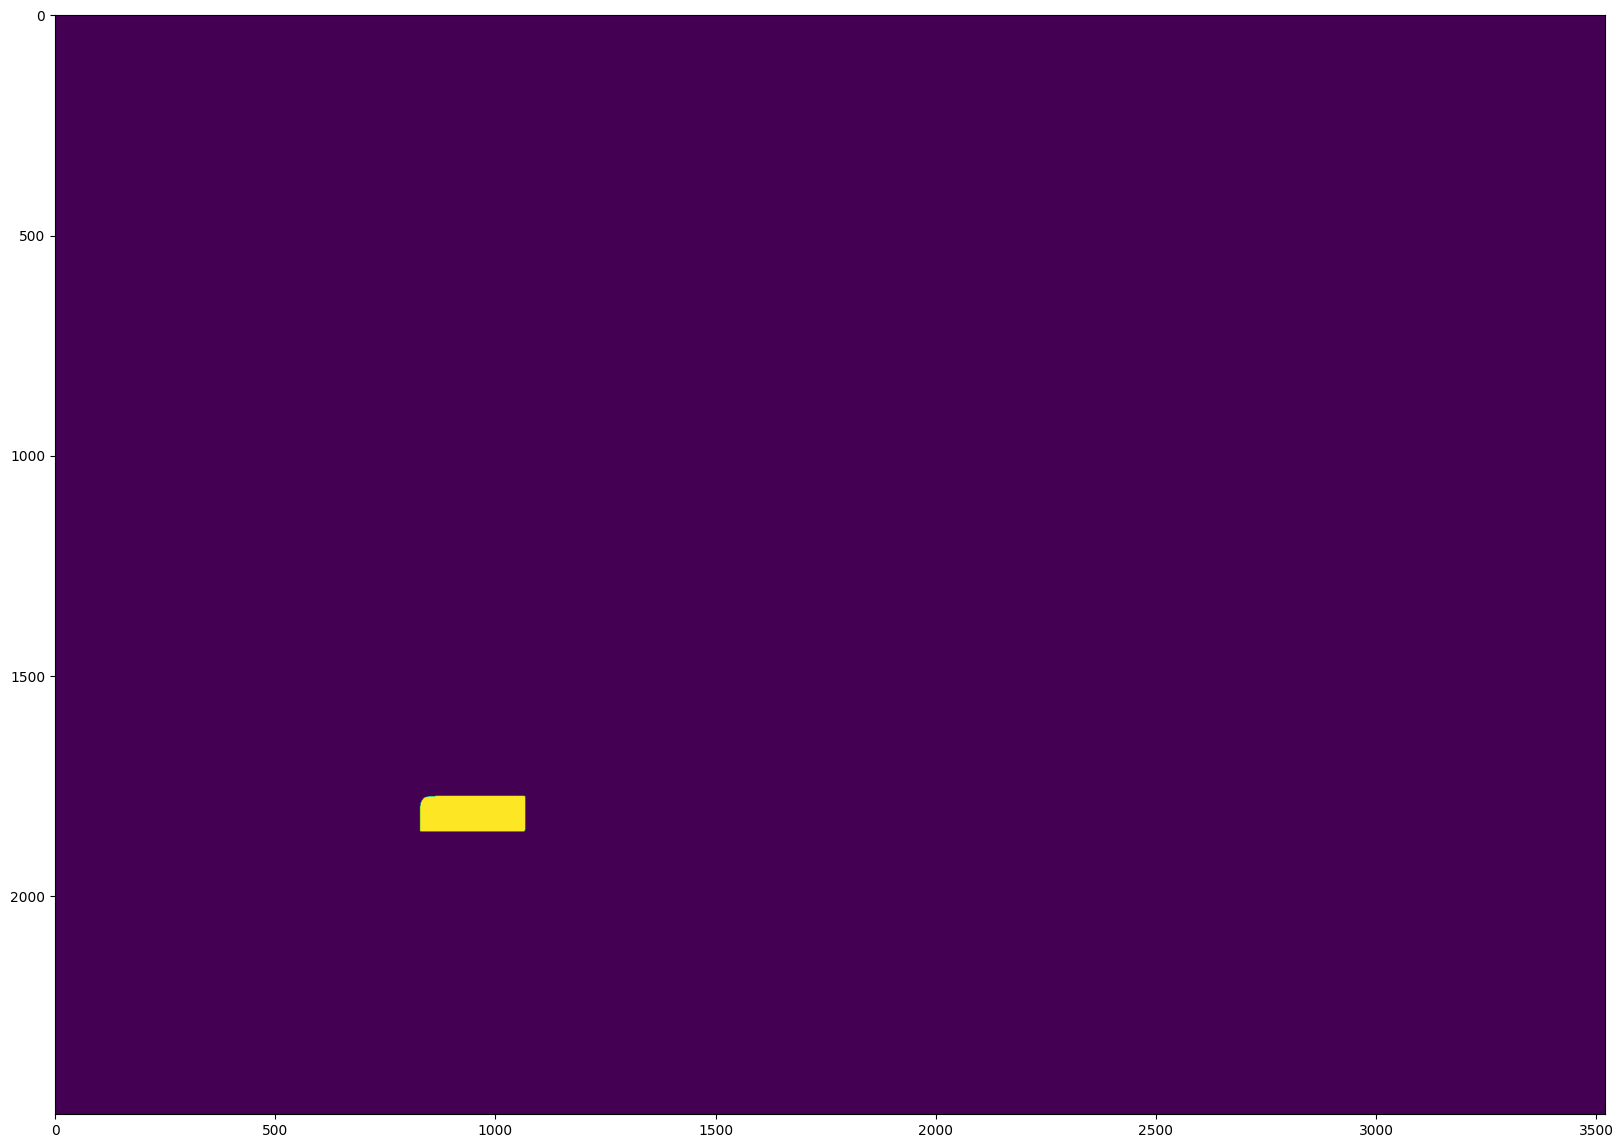

---------------------------output mask after onlymask--------------------------


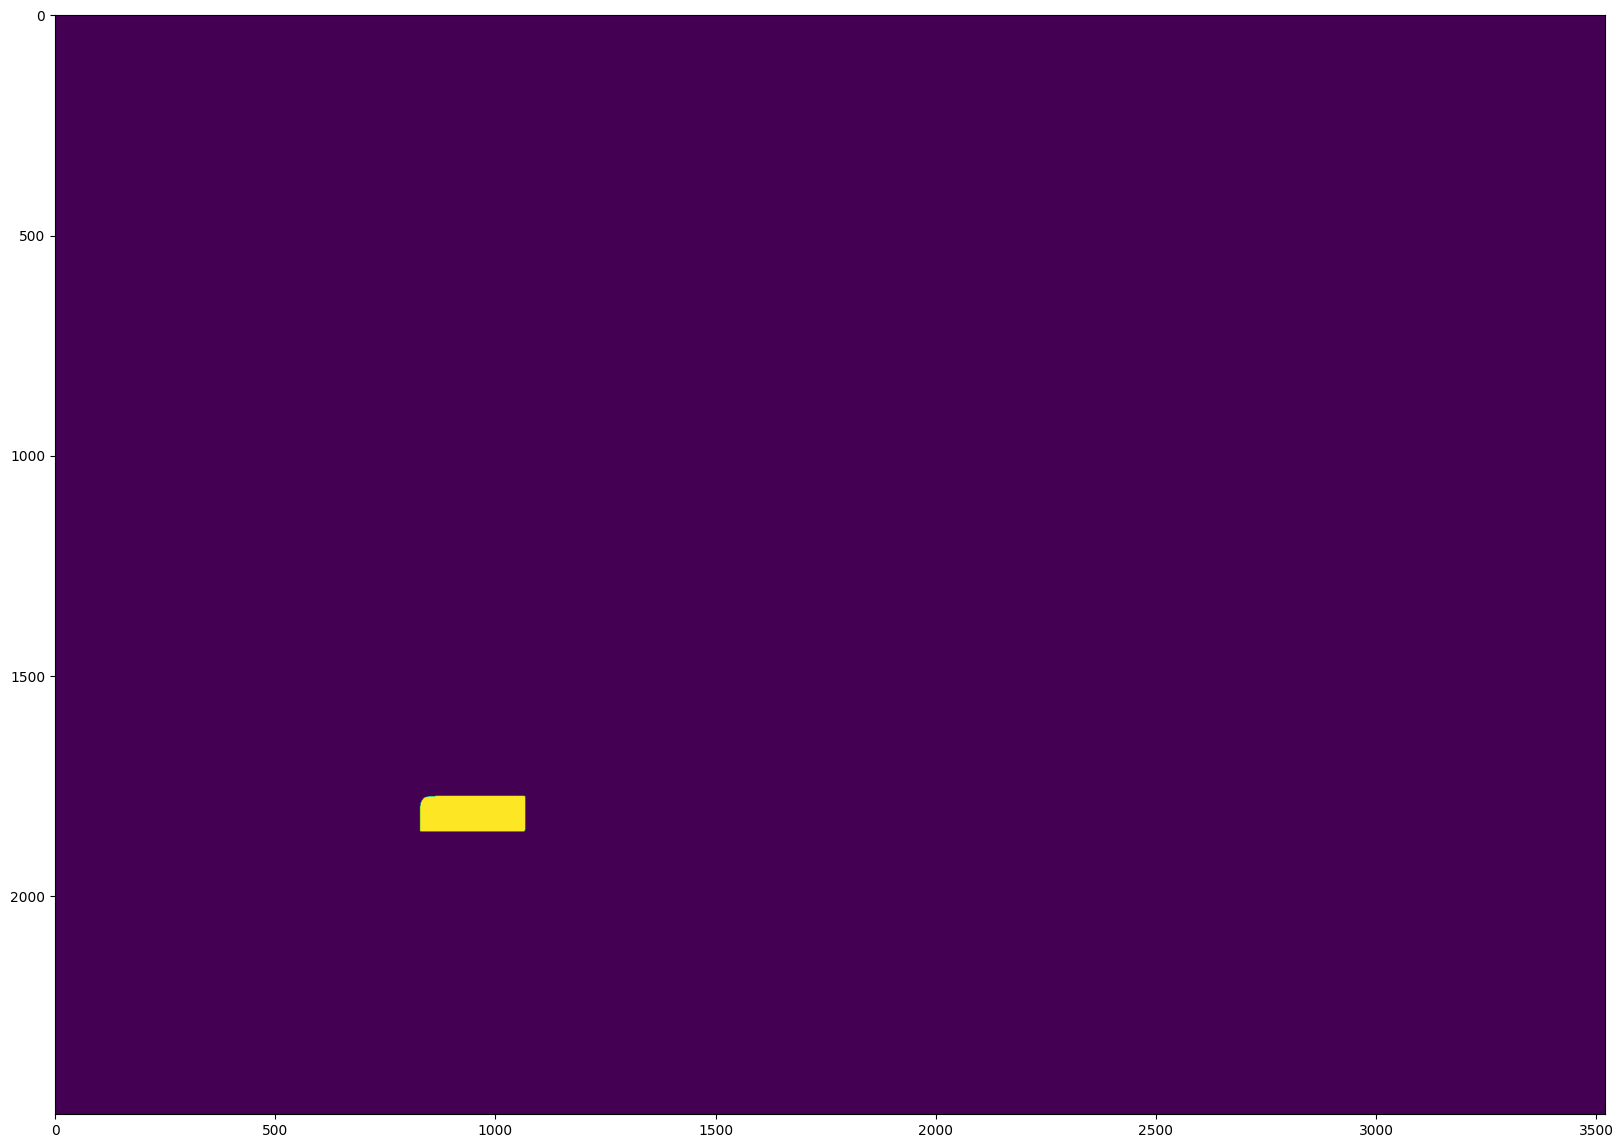

---------------------------onlymask--------------------------


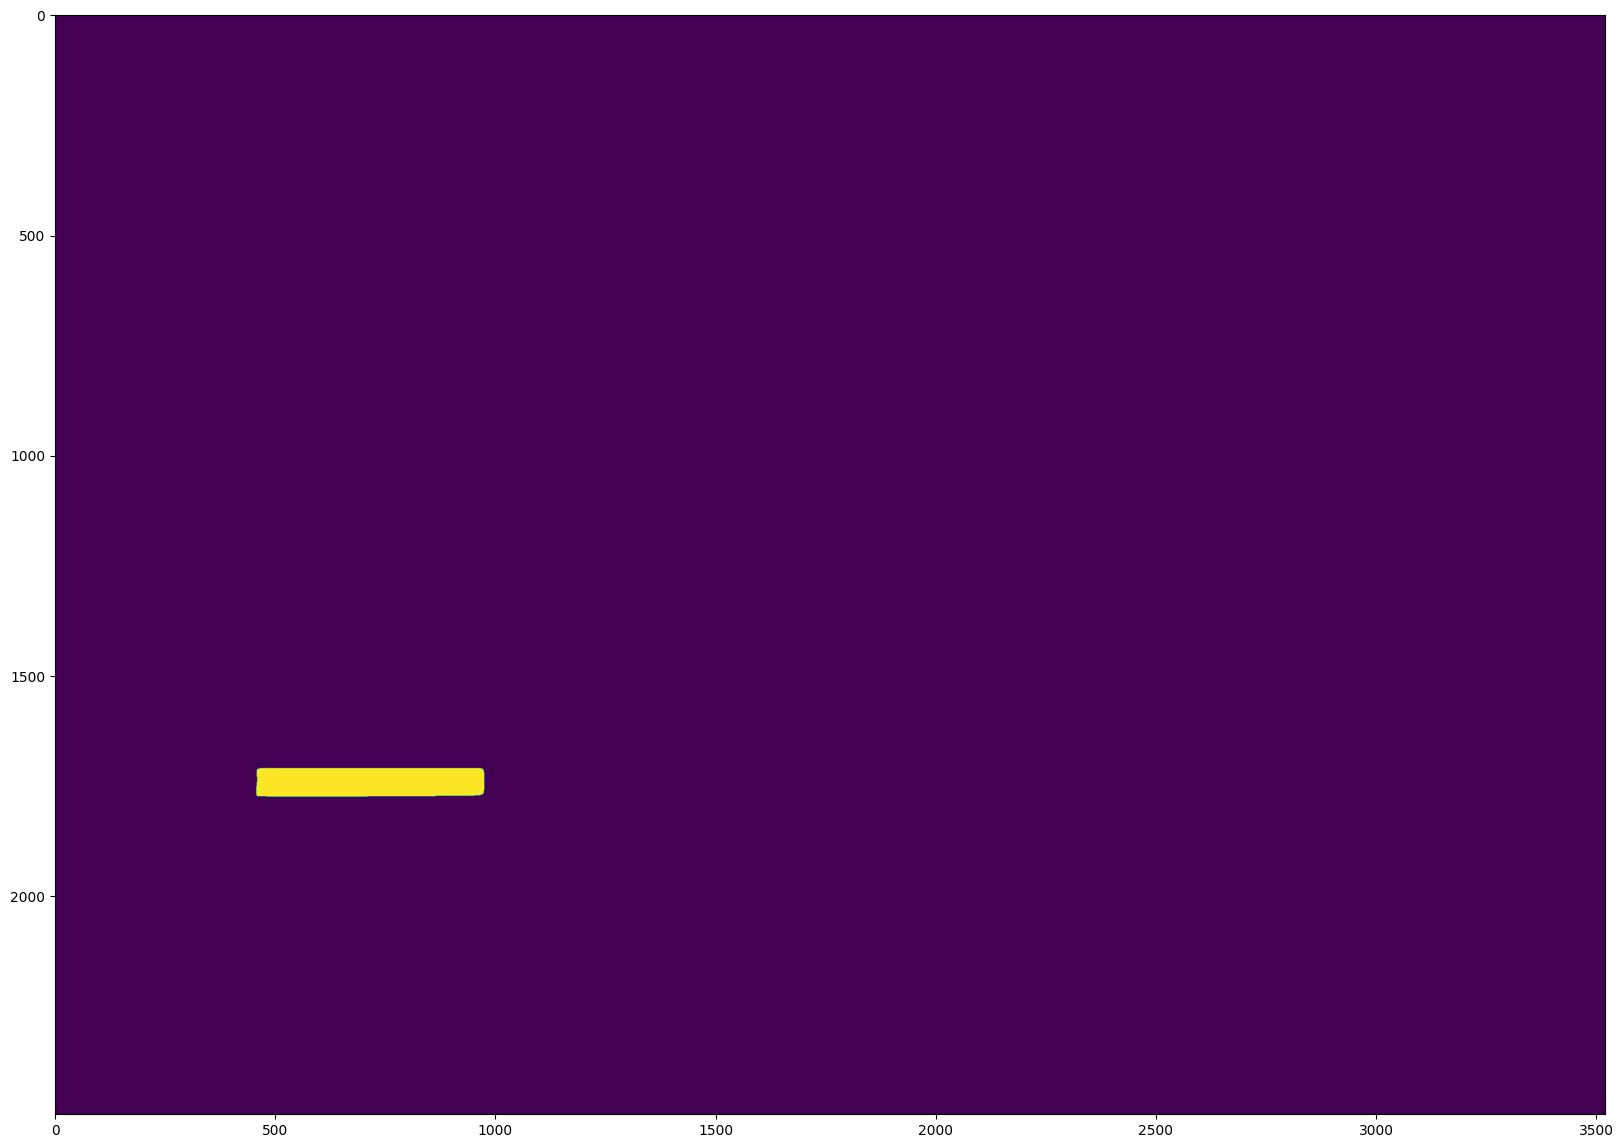

0.9986130374479889 0.5
---------------------------output mask--------------------------


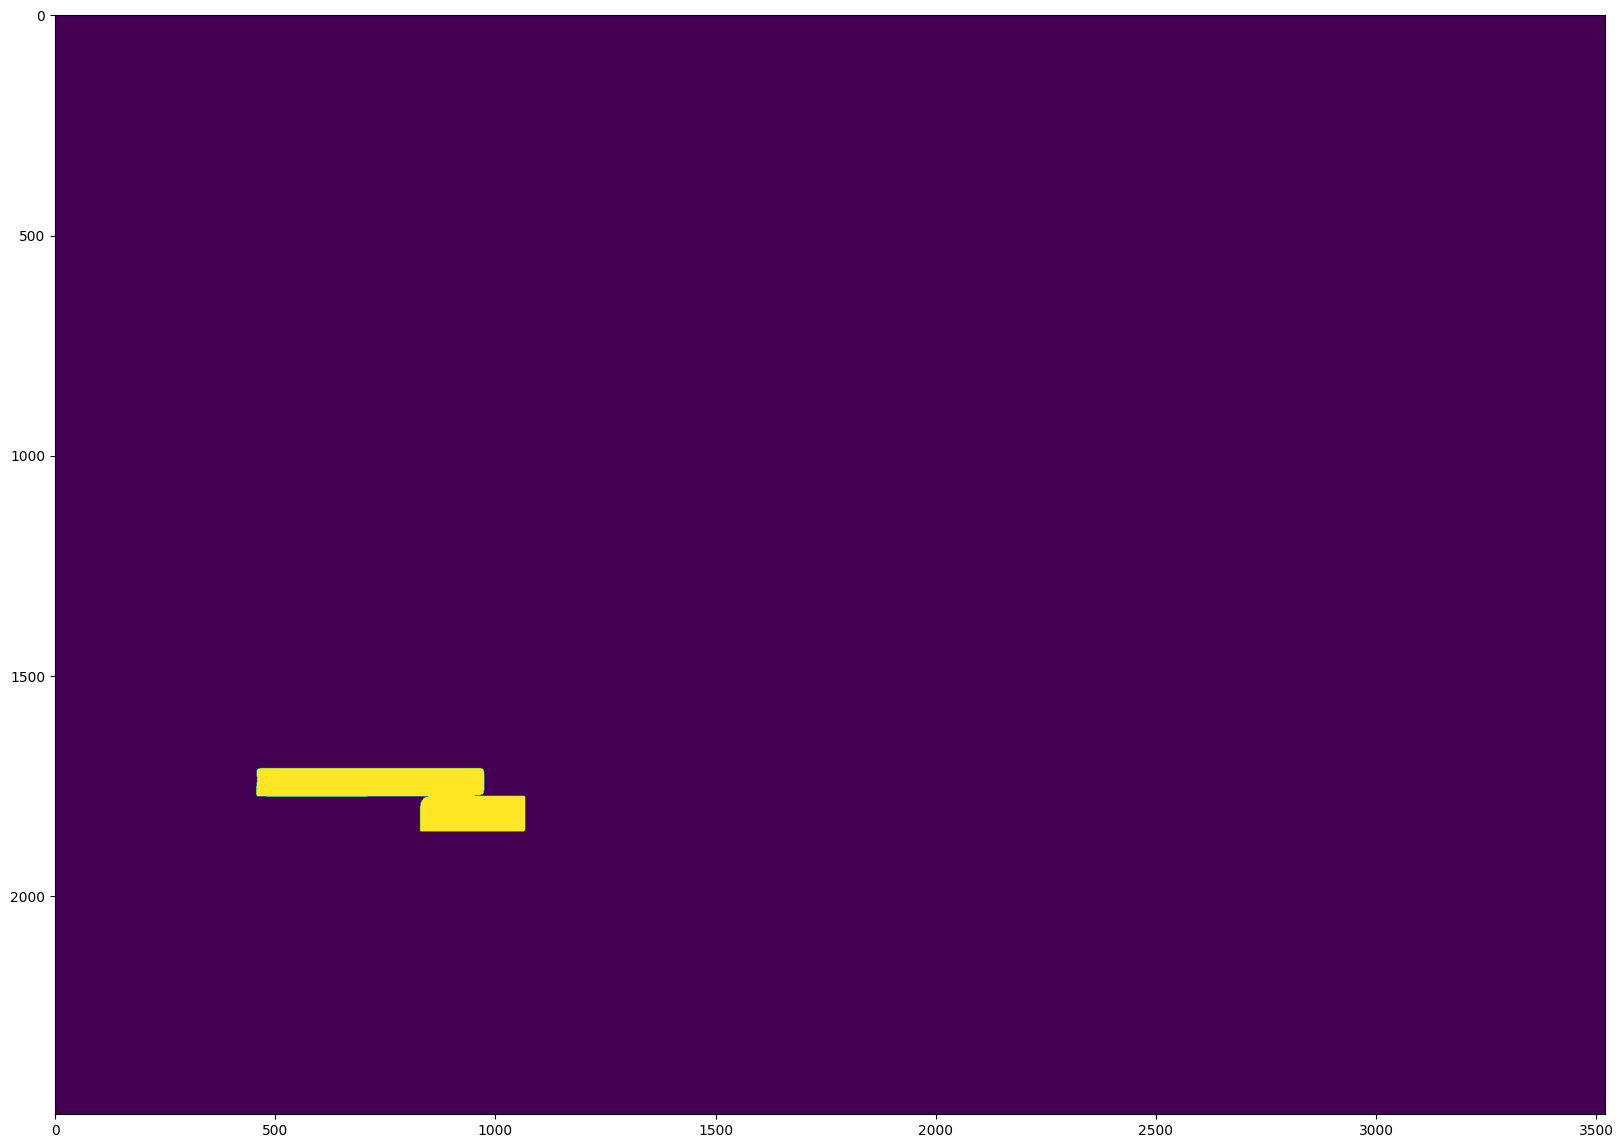

---------------------------output mask--------------------------


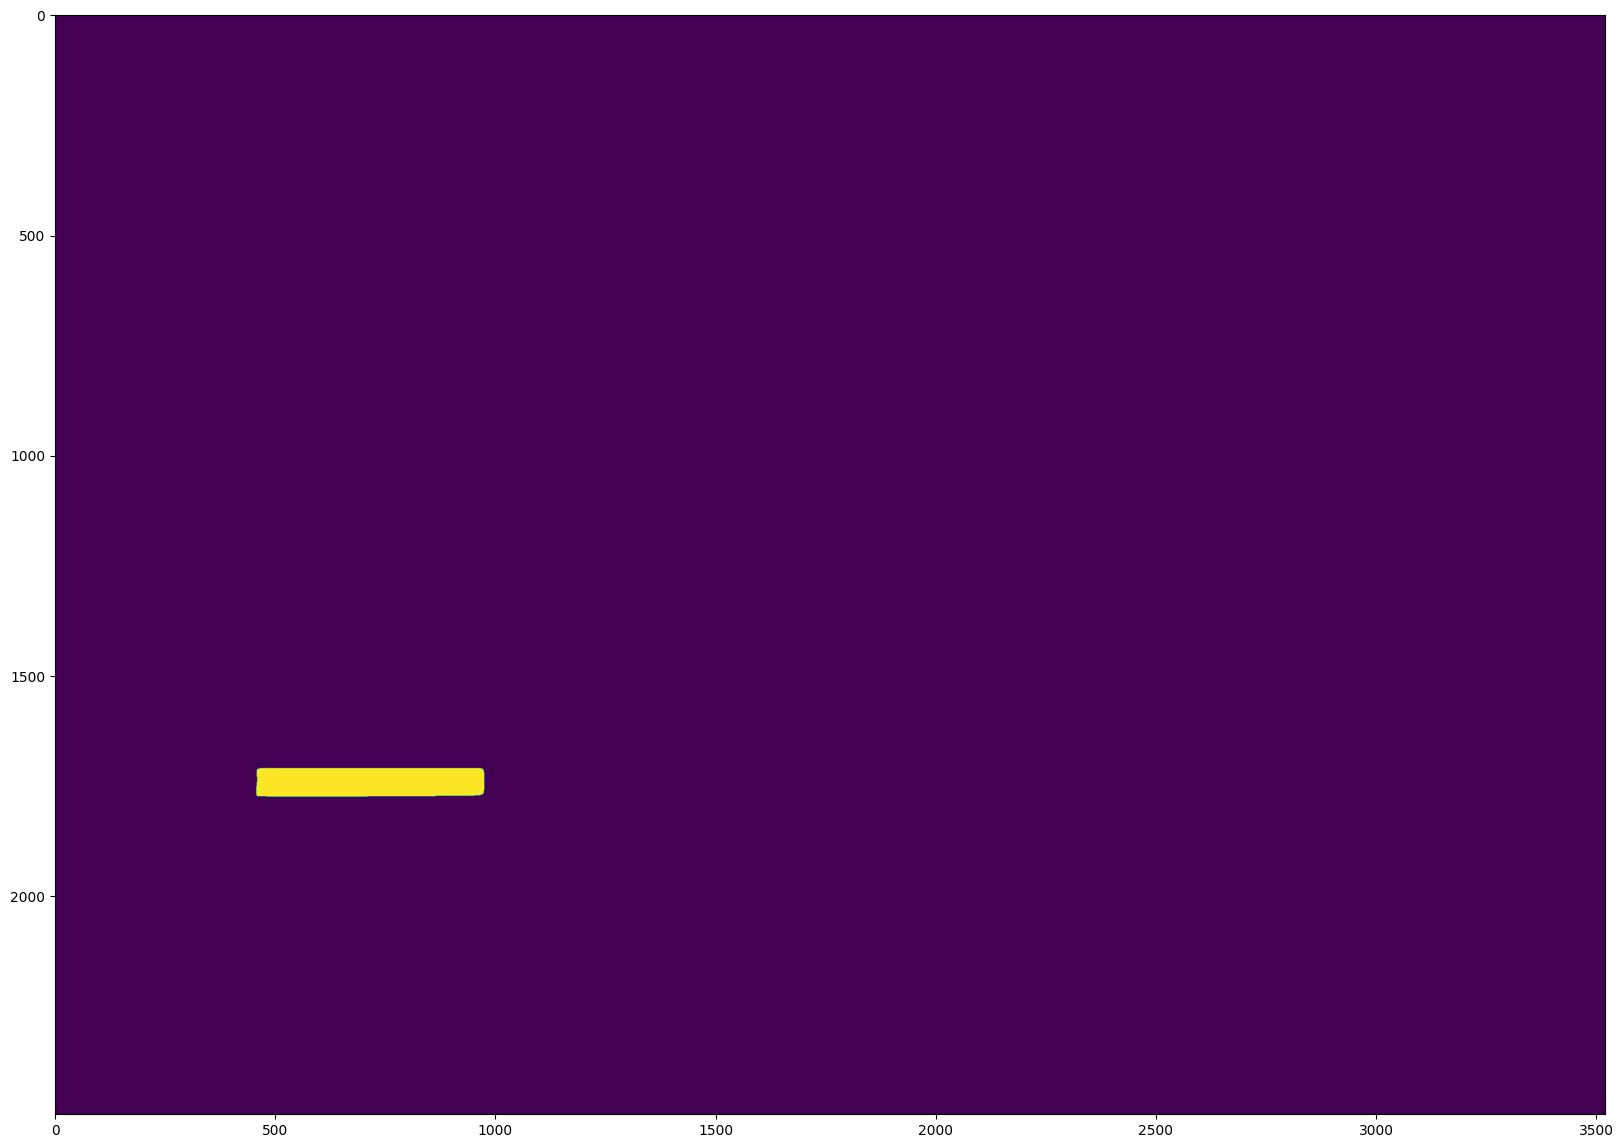

------------------------filtered masks-----------------------------


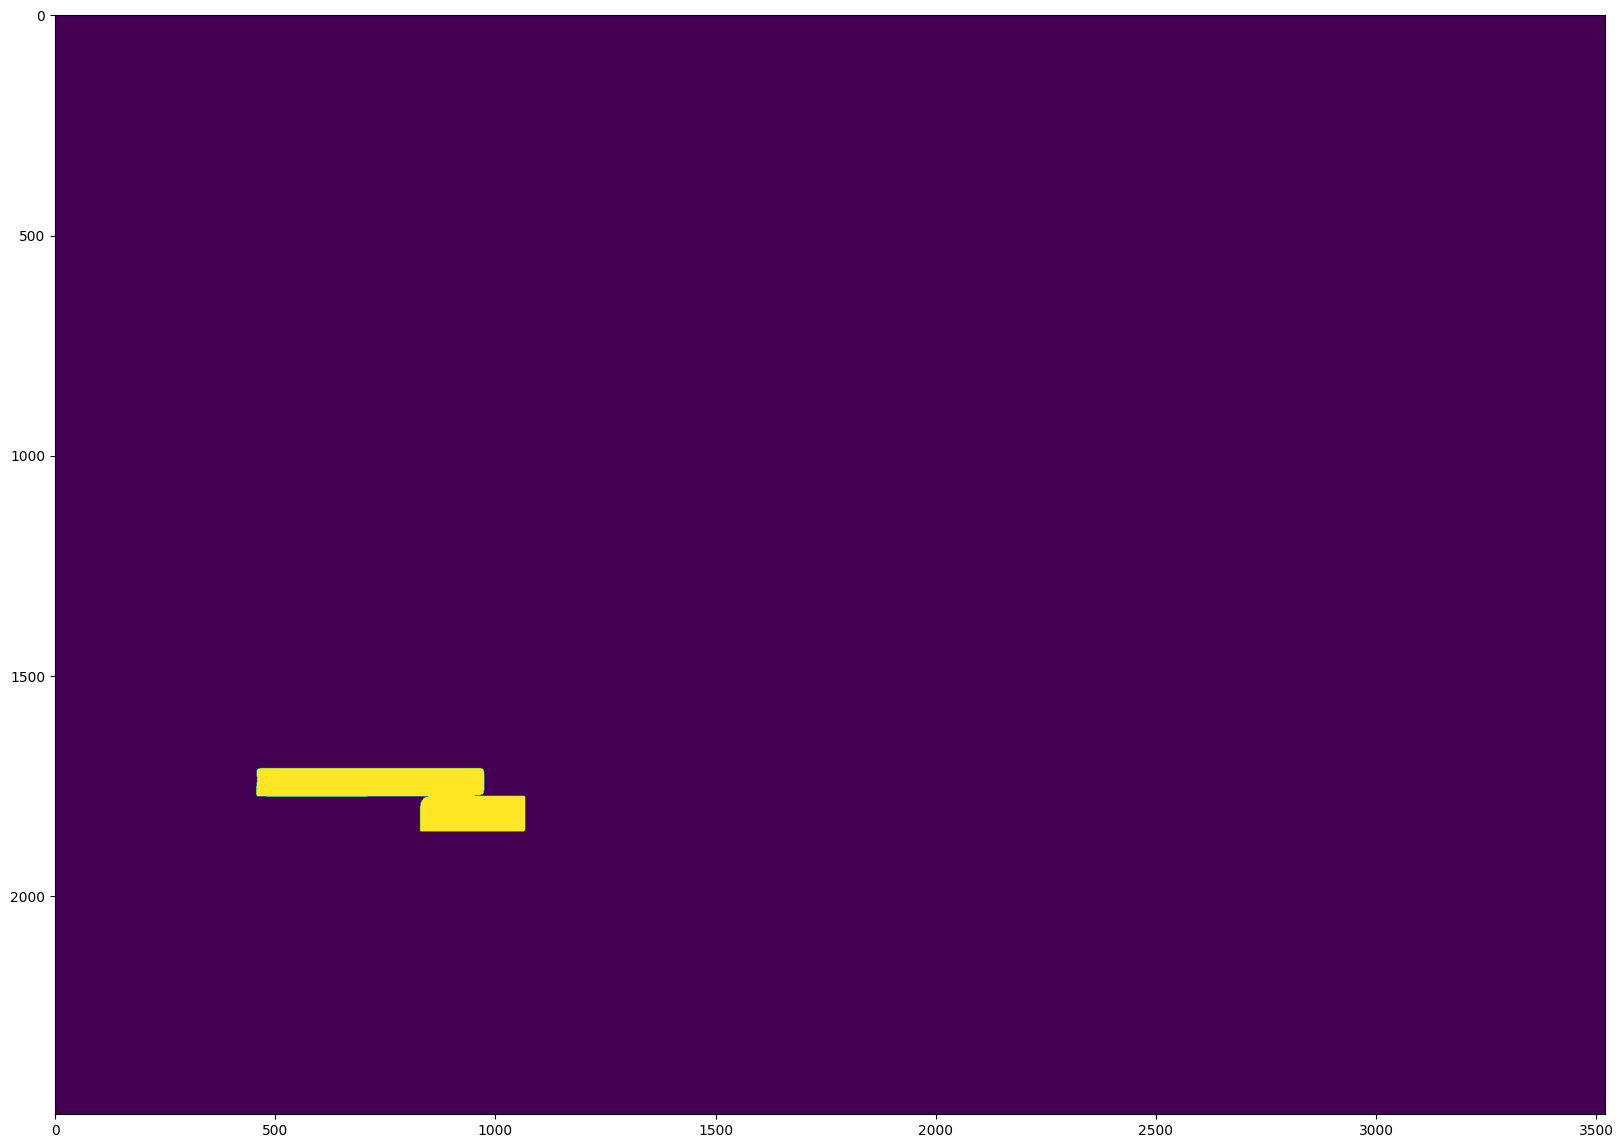

------------------------filtered masks-----------------------------


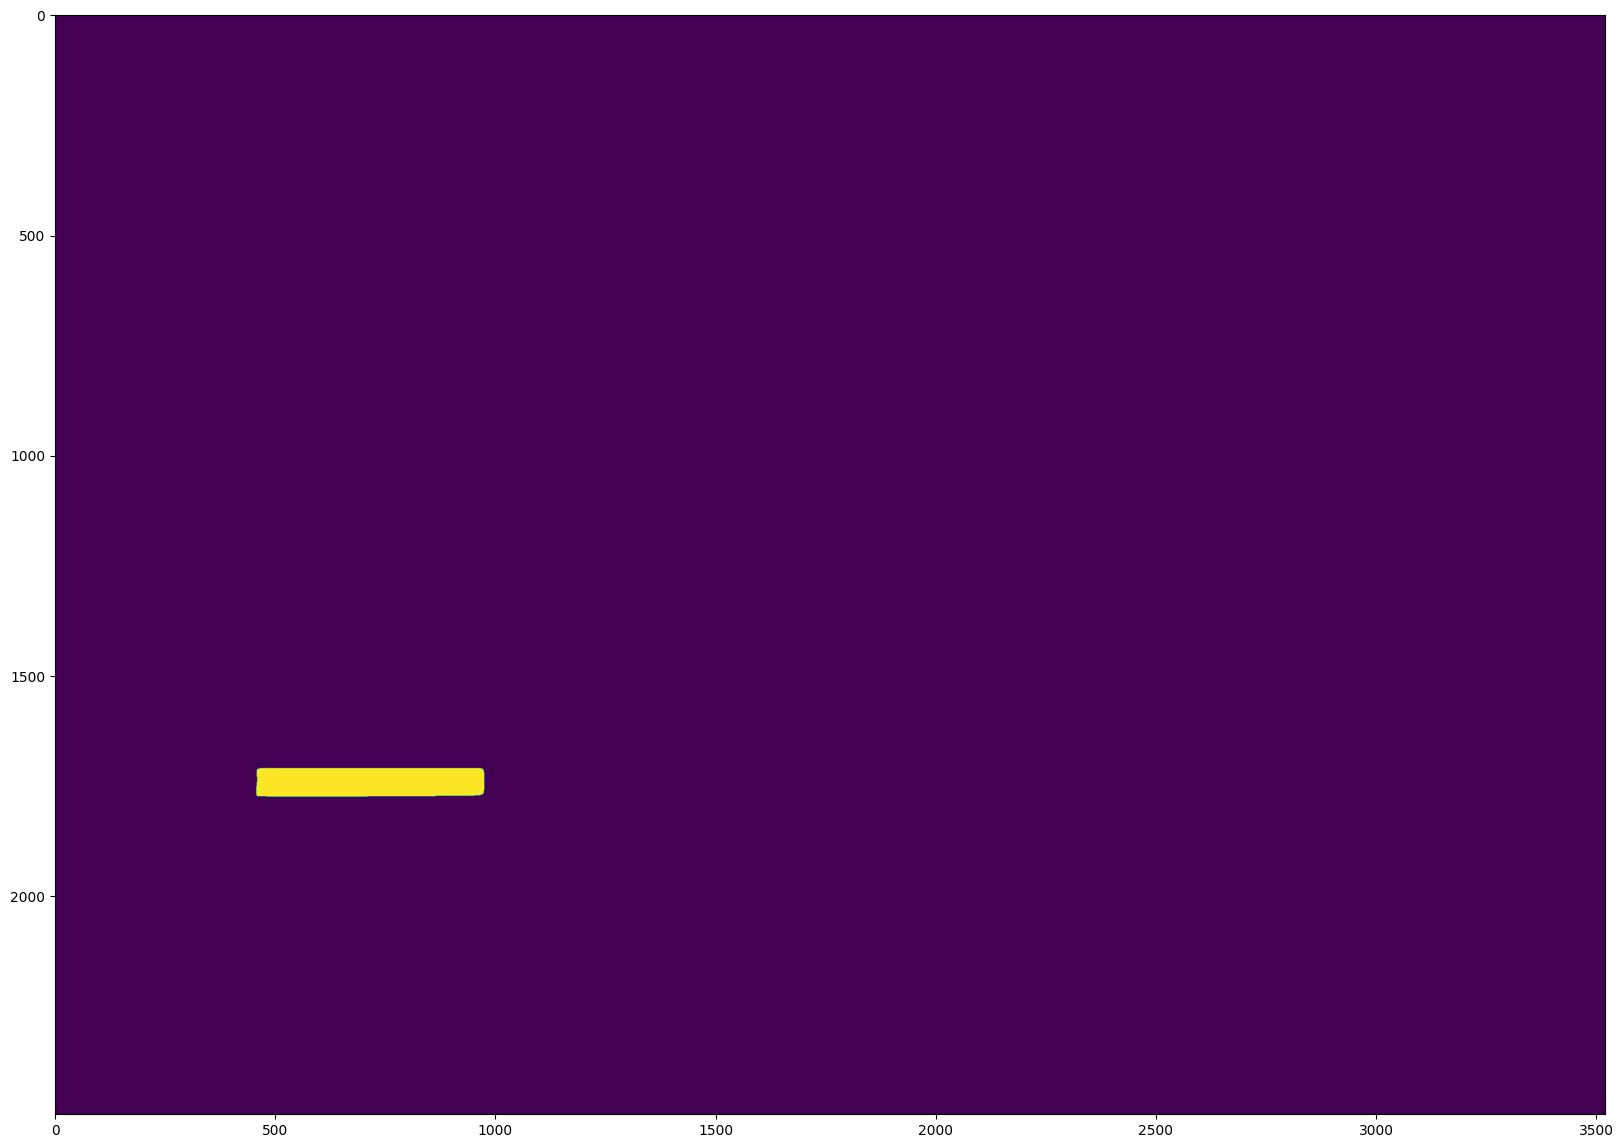

aaaaaaaas (2, 2496, 3520)
0 35910 0 52322
0 0 0.5884206167749834
0 35910 1 33120
0 1 0.8318605206591831
1 19740 0 52322
1 0 0.3489199206319494
1 19740 1 33120
1 1 0.002636520551582861


{'TP': 2,
 'FP': 0,
 'FN': 1,
 'IOU': 1.4202811374341664,
 'area': 85442,
 'size': 8785920,
 'Label': 'gray'}

In [20]:
extract_panoptic_evaluation_values(os.path.join(datasets_dir, 'complete', 'Gelakte stukken Wob-verzoek omgevingsproces Ternaard 2e deel-83.png'))

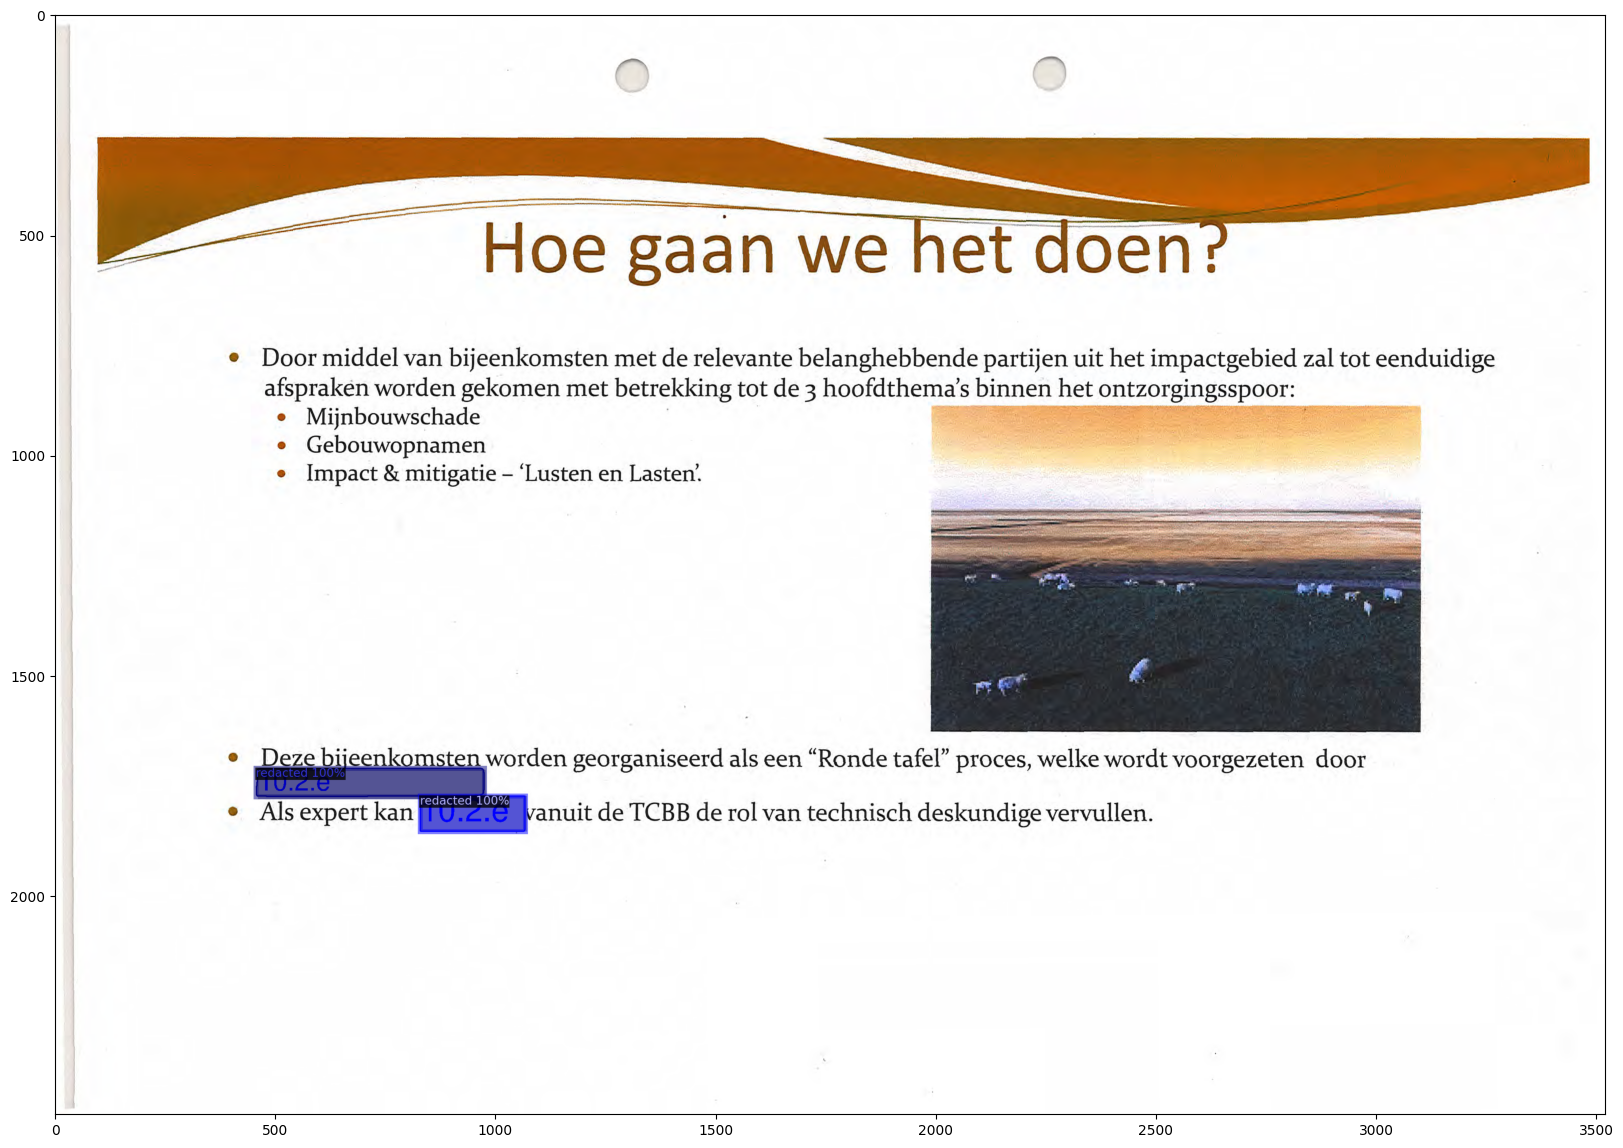

In [172]:
im = cv2.imread(os.path.join(datasets_dir, 'complete', 'Gelakte stukken Wob-verzoek omgevingsproces Ternaard 2e deel-83.png'))
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im, metadata=metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20, 20))
plt.imshow(out.get_image())
plt.show()

In [16]:
def evaluate_dataframe(dataset: list, score_t: float=0.5, iou_t: float= 0.5):
    '''
    Function to get the panoptic quality
    @param  list    A dataset in the DatasetCatalog format 
    @param  float   The prediction confidence score threshold
    @param  float   The interval-over-intersection threshold to consider
                    an annotated region and predicted region a true positive
    '''
    
    # create a dataframe to store the panoptic quality values in
    values = {}
    
    # iterate over the samples
    for sample in tqdm(dataset):
        
        # get the values for the panoptic quality evaluation for this sample
        values[sample['file_name']] = extract_panoptic_evaluation_values(sample['file_name'], score_t, iou_t)

    # return put all values in a dataframe 
    # with the file_name as the index
    return pd.DataFrame(values).T

In [17]:
# get the validation dicts
test_dir = os.path.join(datasets_dir, 'test_extended')
test_dicts = get_redacted_dicts(test_dir)

439it [00:31, 13.89it/s]


In [18]:
# get the dataframe with the evaluation scores
test_df = evaluate_dataframe(test_dicts, 0.5, 0.5)

  0%|          | 0/439 [00:00<?, ?it/s]C:\Users\kdmei\anaconda3\envs\master\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 439/439 [53:30<00:00,  7.31s/it]  


In [19]:
# save the dataframe
test_df.to_csv(os.path.join('results', 'maskrcnn_extended_results.csv'))

In [20]:
# calculates the panoptic quality metrics
results = {}
for label, label_df in test_df.groupby('Label'):
    
    # no_annotation has not true positives, so 
    # all metrics will be 0
    if label == 'no_annotation': continue
    
    results[label] = metric_calculation(label_df)
    
# also add the PQ score of the complete dataset
results['total'] = metric_calculation(test_df)
    
# show the metrics in a pandas dataframe
pd.DataFrame.from_dict(results).T[['PQ', 'SQ', 'RQ', 'P', 'R']]

,PQ,SQ,RQ,P,R
black,0.78,0.82,0.94,0.95,0.93
border,0.77,0.84,0.92,0.96,0.88
color,0.81,0.84,0.96,0.97,0.95
gray,0.74,0.82,0.90,0.93,0.87
total,0.75,0.83,0.90,0.90,0.91


In [21]:
# total number of pages without annotations and the sum of false positives
print(len(test_df[test_df['Label'] == 'no_annotation']))
print(test_df[test_df['Label'] == 'no_annotation']['FP'].sum())

155
203


# Time the model

In [22]:
# the test dir
test_dir = os.path.join(datasets_dir, 'test_extended')

# load the trained model
# !NOTE!: Make sure that the cfg is loaded in a previous cell
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold (in this case the same as the training threshold)
predictor = DefaultPredictor(cfg)

[01/23 16:05:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output_extended\model_final.pth ...


In [23]:
def time_algorithm(input_image_path):
    '''
    Time the image loading and model prediction
    @param  string    The path to the image
    @return dict      The times of the individual parts and total time
    '''
    
    # time the image loading
    load_start = time.time()
    input_image = cv2.imread(input_image_path)
    load_end = time.time()
    
    # time the prediction
    predict_start = time.time()
    outputs = predictor(input_image)
    predict_end = time.time()
    
    # add the separate time differences
    times = {
        'loading': load_end-load_start,
        'predicting': predict_end-predict_start
    }
    
    # add the total time (sum of the individual parts)
    times['total'] = sum(times.values())
    
    # return the times
    return times

In [24]:
# do this over all the images and average
load_times = []
predicting_times = []
total_times = []

# time the model for all test images
for filename in tqdm(os.listdir(test_dir)):
    image_path = os.path.join(test_dir, filename)
    times = time_algorithm(image_path)
    load_times.append(times['loading'])
    predicting_times.append(times['predicting'])
    total_times.append(times['total'])

100%|██████████| 439/439 [02:13<00:00,  3.30it/s]


In [25]:
# print the average times
print("Average loading time is %.3f seconds" % np.mean(load_times))
print("Average predicting time is %.3f seconds" % np.mean(predicting_times))
print("Average total time is %.3f seconds" % np.mean(total_times))

Average loading time is 0.070 seconds
Average predicting time is 0.231 seconds
Average total time is 0.301 seconds
